# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from cycler import cycler
import math

import os

In [2]:
cwd = os.getcwd()

PATH_SALES_DF_TRAIN = cwd + '/data/raw/sales_df_train.csv'
PATH_PR_DF = cwd + '/data/raw/pr_df.csv'
PATH_ST_DF = cwd + '/data/raw/st_df.csv'
PATH_SALES_SUBMITIONS = cwd + '/data/raw/sales_submission.csv'

Для анализа и дальнейшего обучения модели предоставлены следующие датасеты:

**sales_df_train.csv** –данные по продажам за скользящий год для обучения.  
Столбцы: 
st_id – захэшированное id магазина;  
pr_sku_id – захэшированное id товара;  
date – дата;  
pr_sales_type_id – флаг наличия промо;  
pr_sales_in_units – число проданных товаров без признака промо;  
pr_promo_sales_in_units – число проданных товаров с признаком промо;  
pr_sales_in_rub – продажи без признака промо в РУБ;  
pr_promo_sales_in_rub – продажи с признаком промо в РУБ;  

**pr_df.csv** – данные по товарной иерархии. 
Столбцы:  
pr_group_id – захэшированная группа товара;  
pr_cat_id – захэшированная категория товара;  
pr_subcat_id – захэшированная подкатегория товара;  
pr_sku_id – захэшированное id товара;  
pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).

**st_st.csv** – данные по магазинам. 
Столбцы: 
st_id – захэшированное id магазина;  
st_city_id – захэшированное id города;  
st_division_code id – захэшированное id дивизиона;  
st_type_format_id – id формата магазина;  
st_type_loc_id – id тип локации/окружения магазина;  
st_type_size_id – id типа размера магазина;  
st_is_active – флаг активного магазина на данный момент.  

Прогноз необходимо предоставить в следующем формате:

**sales_submission.csv** – пример файла с результатом работы модели прогноза спроса. 
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по 
умолчанию колонка заполнена нулями). 
Столбцы: 
st_id – захэшированное id магазина; 
pr_sku_id – захэшированное id товара;  
date – дата (день);  
target – спрос в ШТ

Начнём изучение данных с датасета sales_df_train

In [3]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
sales_df_train.head()

st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  42a0e188f5033bc65bf8d78622277c4e  8e887cf8e64ab8e7173701a979476567   
4  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   

         date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0  2022-10-20                 1                5.0                      5.0   
1  2023-01-29                 0                4.0                      0.0   
2  2023-03-02                 0                1.0                      0.0   
3  2023-04-05                 1                0.0                      0.0   
4  2023-02-17                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub  
0            825.0                  825.0  
1            196.0                    0.0  
2             78.0                    0.0  
3             69.0                   69.0  
4            161.0                    0.0

In [4]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [5]:
sales_df_train.describe()

pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
count     883015.000000      883015.000000            883015.000000   
mean           0.406486           5.037956                 2.230010   
std            0.491178          13.402984                11.063288   
min            0.000000         -39.000000               -39.000000   
25%            0.000000           1.000000                 0.000000   
50%            0.000000           2.000000                 0.000000   
75%            1.000000           4.000000                 1.000000   
max            1.000000        2348.000000              2348.000000   

       pr_sales_in_rub  pr_promo_sales_in_rub  
count    883015.000000          883015.000000  
mean        596.705181             294.766561  
std        1577.366179            1402.764168  
min       -3373.000000           -3373.000000  
25%          98.000000               0.000000  
50%         224.000000               0.000000  
75%         540.000000             127.000000  
max      183265.000000          183265.000000

В данных нет пропусков, однако столбец с датой необходимо привести к  формату datetime и упорядочить по данному столбцу, поскольку сейчас данные записаны в разнобой, в столбцах pr_sales_in_units, pr_promo_sales_in_units, pr_sales_in_rub, pr_promo_sales_in_rub есть отрицательные значения, вероятнее всего это возвраты товаров.

In [6]:
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'])

In [7]:
sales_df_train = sales_df_train.sort_values(by=['date', 'st_id', 'pr_sku_id'])

Посмотрим максимальную и минимальную дату в датасете

In [8]:
sales_df_train['date'].min(), sales_df_train['date'].max()

(Timestamp('2022-08-01 00:00:00'), Timestamp('2023-07-18 00:00:00'))

В наличии есть данные чуть больше чем за год. К сожалению это не позволит нам проанализировать и использовать годовые патерны (не получиться учесть годовую сезонность).

## Анализ общего числа продаж

Проанализируем изменение общего числа продаж всех товаров, для этого сгруппируем данные по дате и агрегируем по сумме число проданных товаров по промо и без промо.

In [9]:
df_ts = sales_df_train.groupby('date')[['pr_sales_in_units','pr_promo_sales_in_units']].agg('sum').resample("1D").sum()

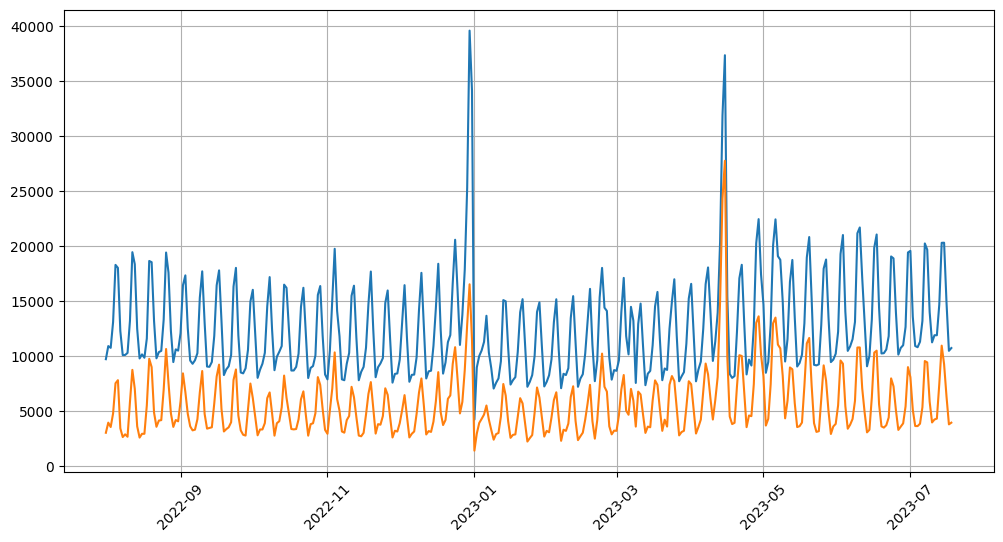

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df_ts)
plt.grid()
plt.xticks(rotation=45)
plt.show()

В графиках явно просматривается сезонность причём она характерна как для обычных товаров, так и для акционных. Кроме того на выходные и праздничные дни присутсвуют пики в праздничные дни. Так же есть два максимальных пика один 31 декабря (вероятно, связаный с новым годом), второй в середине апреля, попорбуем определить на какую дату он попал.

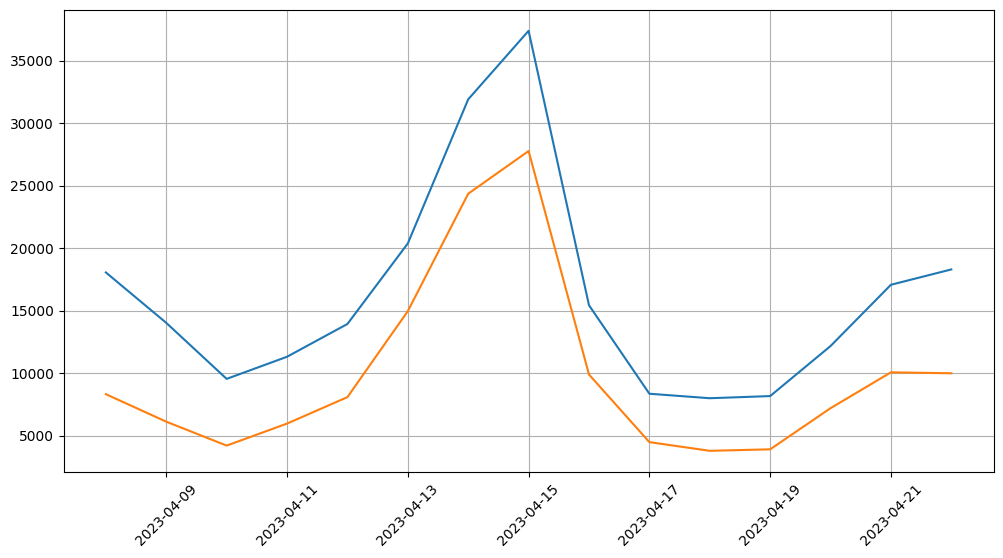

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df_ts['2023-04-08':'2023-04-22'])
plt.grid()
plt.xticks(rotation=45)
plt.show()

Данный праздник выпадает на 15 апреля. Первоначально было предположение, что это связано с погодой, но 15 и 16 апреля в 2023 году не отличалось особо хорошей погодой, однако 16 апреля была православная пасха, можно выдвинуть гипотезу, что именно это и является причиной, но чтобы это проверить, требуется срез за более ранний период (желательно за несколько лет). Поскольку Новый год и пасха даёт прирост примерно одного порядка, то для них лучше сделать отдельный признак.

Также после нового года наблюдается спад продаж

Проанализируем наличие отрицательных значений в датасете, посчитаем количество таких строк

In [12]:
sales_df_train[(sales_df_train['pr_sales_in_units']<0) |
               (sales_df_train['pr_promo_sales_in_units']<0) |
               (sales_df_train['pr_sales_in_rub']<0) |
               (sales_df_train['pr_promo_sales_in_rub']<0)]['pr_sku_id'].count()

79

Всего таких строк 79, вероятнее всего это действительно возвраты. Учитывая что общее количество строк в датасете 883015, то удалим эти строки на предобработке

Посмотрим как часто встречаются строки с 0 в pr_sales_in_units и pr_promo_sales_in_units (т.е. продажи с 0 количеством)

In [13]:
sales_df_train[(sales_df_train['pr_sales_in_units']==0) &
               (sales_df_train['pr_promo_sales_in_units']==0)]['pr_sku_id'].count()

66543

In [14]:
sales_df_train[(sales_df_train['pr_sales_in_units']==0) &
               (sales_df_train['pr_promo_sales_in_units']==0)]['pr_sku_id'].count() / len(sales_df_train)

0.0753588557385775

Таких строк 7,5% от общего количества строк, это достаточно большой объём данных, нужно будет разобраться в причинах таких нулей. 

Посмотрим на сезонность в данных

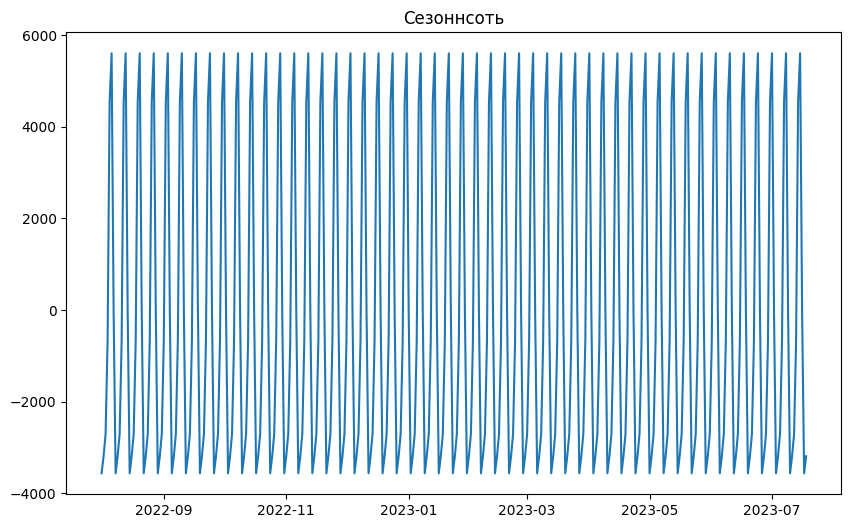

In [15]:
decomposed = seasonal_decompose(df_ts['pr_sales_in_units'])
plt.figure(figsize=(10,6))
plt.plot(decomposed.seasonal)
plt.title('Сезоннсоть')
plt.show()

Как и предполагалось в данных есть сезонность, сденлаем срез, чтобы увеличить данные и лучше её рассмотреть.

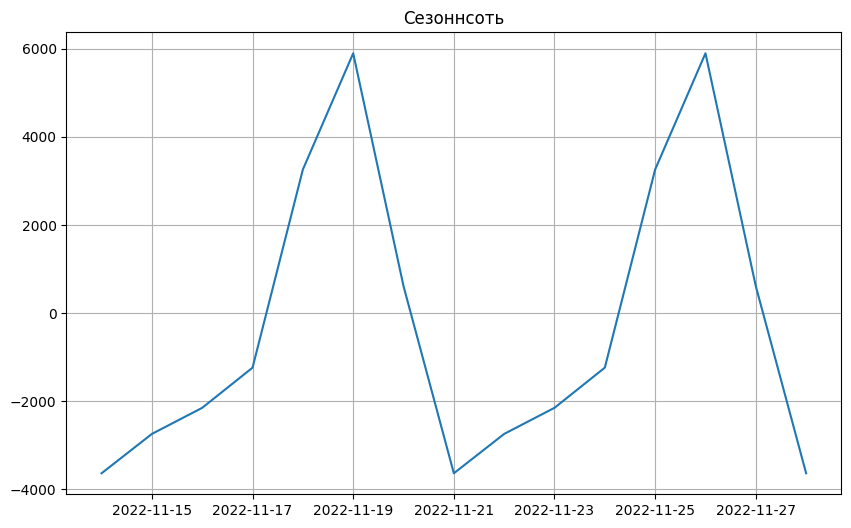

In [16]:
decomposed = seasonal_decompose(df_ts['2022-11-14':'2022-11-28']['pr_sales_in_units'])
plt.figure(figsize=(10,6))
plt.plot(decomposed.seasonal)
plt.title('Сезоннсоть')
plt.grid()
plt.show()

Сезонность по продажам составляет примерно неделю. Поэтому в качестве признака разумно использовать лаг в 7 дней.

Посмотрим на какой день недели приходится пик. Ниже приведены номера дней недели с пиками на основании срезов (вывод графиков удалён, чтобы не загромождать тетрадку)

In [17]:
datetime.strptime('2023-11-19', '%Y-%m-%d').weekday()

6

In [18]:
datetime.strptime('2023-05-27', '%Y-%m-%d').weekday()

5

In [19]:
datetime.strptime('2023-01-21', '%Y-%m-%d').weekday()

5

In [20]:
datetime.strptime('2023-10-15', '%Y-%m-%d').weekday()

6

Пики продаж приходятся чаще всего на конец недели (видимо сказываются выходные дни), а минимумы продаж на начало рабочей недели.

In [21]:
del df_ts, decomposed

### Выводы

1. Даные предоставлены в срезе с 2022-08-01 по 2023-07-18.
2. В данных наблюдается недельная сезонность с пиками в выходные дни.
3. Также наблюдаются пики в дни государственных праздников РФ.
4. Есть 2 больших пика по продажам 31 декабря (в связи с новым годом) и 15 апреля (предположительно связан с православной пасхой). При этом после этих пиков наблюдается спад продаж.

**Обобщение:**

В качестве признаков в модель нужно будет добавить: 
* лаги в неделю, плюс посмотреть, возможно лучше себя покажет среднее из лагов 6 - 8 дней, поскольку сезонность иногда сжимается.
* флаг буднего / выходного дня
* день недели (закодировать через OneHotEncoder
* флаг государственных праздников РФ
* флаг нового года и пасхи
* флаг, что это неделя идёт после нового года и пасхи
* в выходных днях учесть переносы праздников (посмотреть постановления правительства о переносах на 2022, 2023 год)

## Анализ магазинов

Для начала проанализируем данные из датасета sales_df_train, посмотрим сколько магазинов встречается в датасете и как часто они попадаются

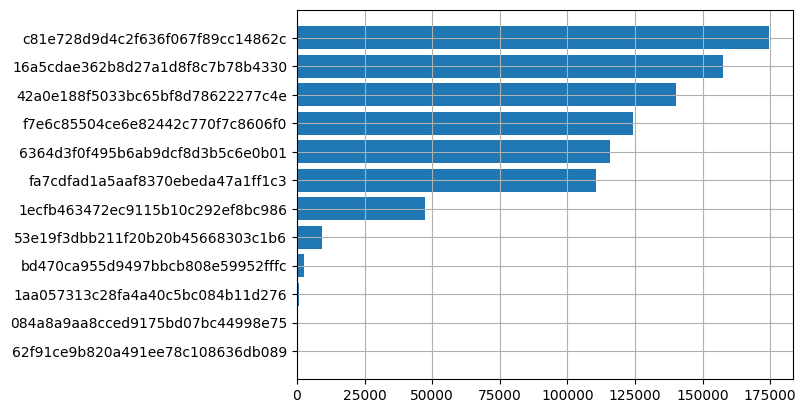

In [22]:
df_st_id = (sales_df_train.groupby('st_id')['pr_sales_in_units'].agg('count')
                  .reset_index(drop=False)
                  .sort_values(by='pr_sales_in_units'))

plt.barh(df_st_id['st_id'], df_st_id['pr_sales_in_units'])
plt.grid()
plt.show()

Как видим магазинов всего 12 штук при этом можно выделить несколько групп. При этом наблюдается разброс по количеству вхождений. Это может быть связано как с тем, что какие-то магазины пополярнее других, так и с тем, что есть новые магазины и общее значение вхождений у них значително меньше. Однако модель времяных рядов не сможет корректно обучиться на коротких датасетах. Поэтому посчитаем, сколько разных дат указано для каждого магазина.

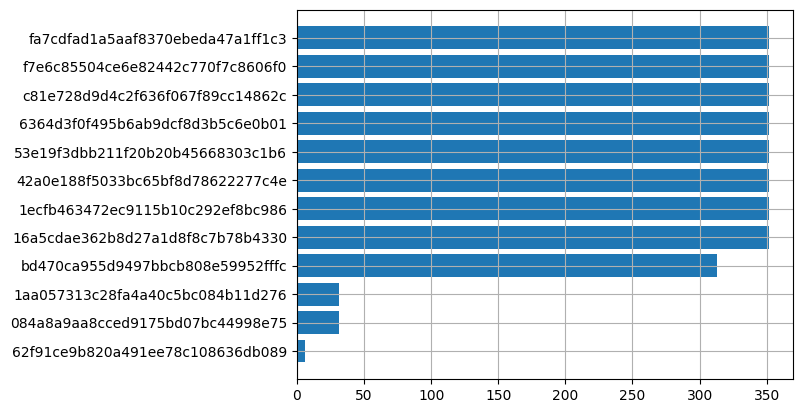

In [23]:
df_count_date = (sales_df_train[['date', 'st_id']]
                 .drop_duplicates()
                 .groupby('st_id')
                 .agg('count')
                 .reset_index(drop=False)
                 .sort_values(by='date'))

plt.barh(df_count_date['st_id'], df_count_date['date'])
plt.grid()
plt.show()

Как видим три магазина имеют слишком малое количество вхождений обучить по корректно модель для них вряд ли удастся. Также ещё один магазин имеет неполную историю, возможн он закрылся, но у него относительно не много пропусков.

Посмотрим на среднее количество товаров проданных в каждом магазине с учётом промо и без него

In [24]:
df_st_id = (sales_df_train.groupby('st_id')[['pr_sales_in_units', 'pr_promo_sales_in_units']].agg('mean')
                  .reset_index(drop=False)
                  .sort_values(by='pr_sales_in_units'))

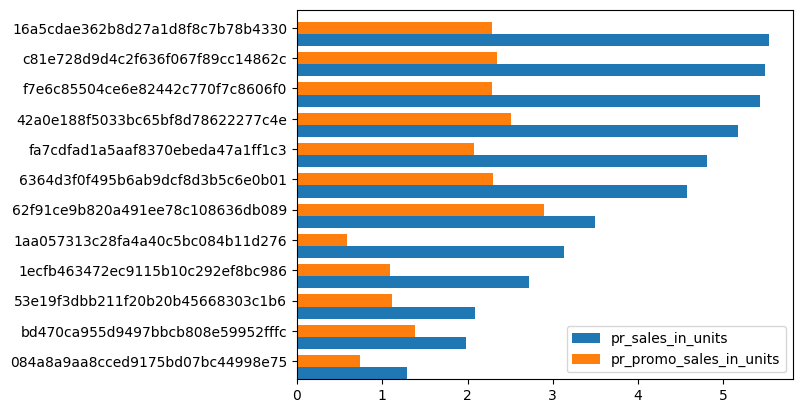

In [25]:
ind = np.arange(len(df_st_id))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df_st_id['pr_sales_in_units'], width, label='pr_sales_in_units')
ax.barh(ind + width, df_st_id['pr_promo_sales_in_units'], width, label='pr_promo_sales_in_units')

ax.set(yticks=ind + width, yticklabels=df_st_id['st_id'], ylim=[2*width - 1, len(df_st_id)])
ax.legend()
plt.show()

На основании полученной диаграммы можно выделить следующие группы магазинов по среднему количеству проданных товаров:
* Магазины со средним значением меньше 2,5
* Магазины со средним значением от 2,5 до 4
* Магазины со средним значением от 4 до 5
* Магазины со средним значением свыше 5

Однако выбросы в течении года могут сильно повлиять на данный показатель, поэтому построим графики со скользящим средним (периодом в месяц).

In [26]:
def get_df_ts_store(df, store_columns):
    df_st_id = df.groupby(['date',store_columns])[['pr_sales_in_units','pr_promo_sales_in_units']].agg('sum').reset_index(drop=False)
    df_st_id.index = df_st_id['date']
    df_st_id = df_st_id.drop('date', axis=1)
    return df_st_id

In [27]:
df_st_id = get_df_ts_store(sales_df_train, 'st_id')

In [28]:
def get_rolling_mean(df, group_column, cloumn):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name = f'rolling_mean_{cloumn}'
        df.loc[df[group_column]==gr_col, new_name] = (df[df[group_column]==gr_col][cloumn]
                                                                    .shift()
                                                                    .rolling(30)
                                                                    .mean())
    df = df.drop(cloumn, axis=1)
    return df

In [29]:
df_st_id = get_rolling_mean(df_st_id, 'st_id', 'pr_sales_in_units')
df_st_id = get_rolling_mean(df_st_id, 'st_id', 'pr_promo_sales_in_units')

In [30]:
def visualize_stores(df, column_store, column_visualizetion):
    colors = ['darkblue', 'orange', 'steelblue', 'pink', 'greenyellow', 'green',
              'coral', 'black', 'yellow', 'red', 'olivedrab','coral']

    styles = ['-', '-', '-', '-', '-', '-',
              '-', '-', '-.', '-.', '-.', '-.']

    plt.rc('axes', prop_cycle=cycler(color=colors, linestyle=styles))
    
    plt.figure(figsize=(12,8))
    for gr_col in sorted(df[column_store].unique()):
        plt.plot(df.loc[df[column_store] == gr_col, column_visualizetion], label=gr_col)
    plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left')
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

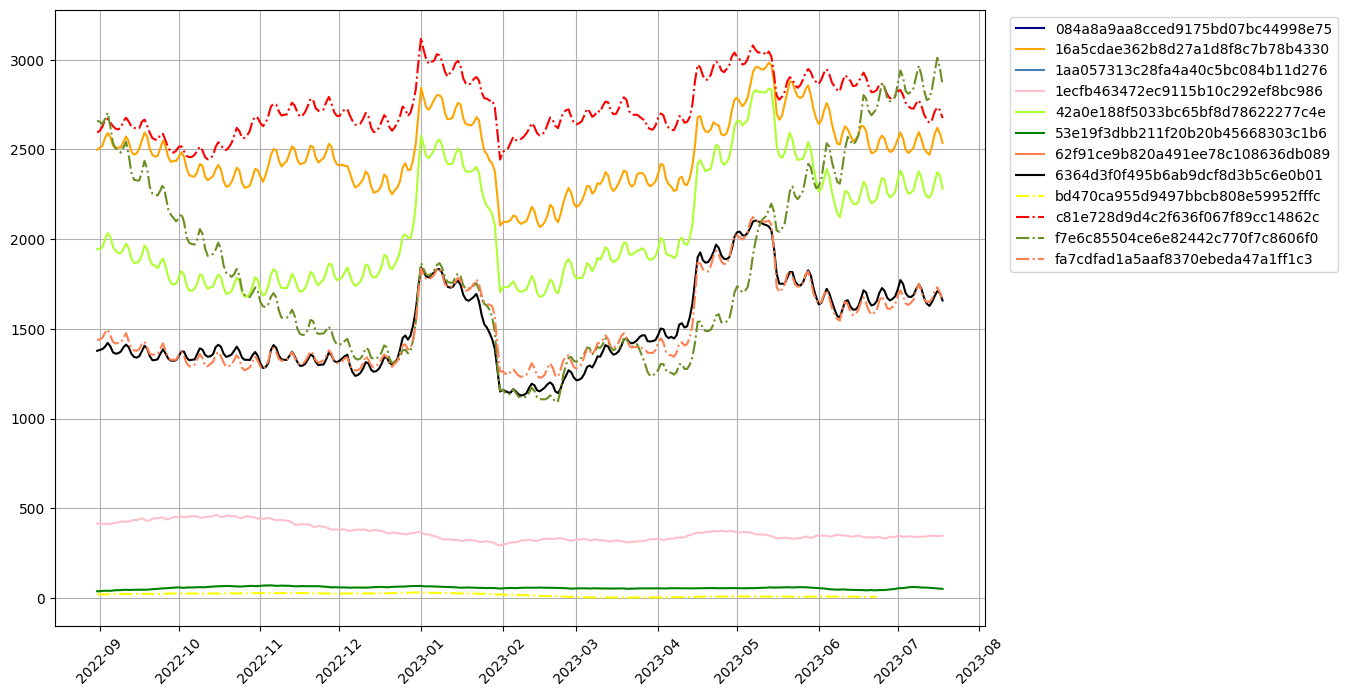

In [31]:
visualize_stores(df_st_id, 'st_id', 'rolling_mean_pr_sales_in_units')

По графику видно, что хорошо выделяется группа магазинов со месячным скользящим среднем меньше 500 (у них координально отличается поведение). У остальных магазинов, кроме жёлтого идёт схожее изменение продаж, отличается только количество.
Поведение магазино с жёлтым графиком весьма странное он перестраивается из топовых магазинов в среднии, затем возвращается обратно. При этом это может быть связано как с обратной сезонностью (например это единственный магазин в южной части страны и у него обратная сезонность), либо это связано с неизвестным фактором, но для этого нужен срез за больший период. Однако пока примем решение делать для него отдельную модель.

Возможно стоит выделить в отдельную модель магазины среднего уровня, со скользящим среднимбольше 500 до 1800

Чтобы выделить магазины с обратной сезонностью будем смотреть отношение скользящего среднего 1 июля к 1 января

In [32]:
def get_ratio_summer_winter(df):
    df_july = df.loc['2023-07-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    df_jan = df.loc['2023-01-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    new_df = df_july.merge(df_jan, on='st_id', how='left')
    new_df['ratio_summer_winter'] = new_df['rolling_mean_pr_sales_in_units_x'] / new_df['rolling_mean_pr_sales_in_units_y']
    return new_df[['st_id', 'ratio_summer_winter']]

In [33]:
get_ratio_summer_winter(df_st_id)

st_id  ratio_summer_winter
0  16a5cdae362b8d27a1d8f8c7b78b4330             0.899185
1  1ecfb463472ec9115b10c292ef8bc986             0.934230
2  42a0e188f5033bc65bf8d78622277c4e             0.905662
3  53e19f3dbb211f20b20b45668303c1b6             0.800000
4  6364d3f0f495b6ab9dcf8d3b5c6e0b01             0.933398
5  c81e728d9d4c2f636f067f89cc14862c             0.904724
6  f7e6c85504ce6e82442c770f7c8606f0             1.536458
7  fa7cdfad1a5aaf8370ebeda47a1ff1c3             0.918716

Соответственно к таким магазинам будем относить те, у которых ratio_summer_winter будет больше 1 (по факту это будет означать, что летом продаж больше, чем зимой)

Расмотрим как меняется доля скользящего среднего по товарам по акции и без акции

In [34]:
df_st_id['sale_ratio_rm_promo_to_non_promo'] = df_st_id['rolling_mean_pr_promo_sales_in_units'] / df_st_id['rolling_mean_pr_sales_in_units']

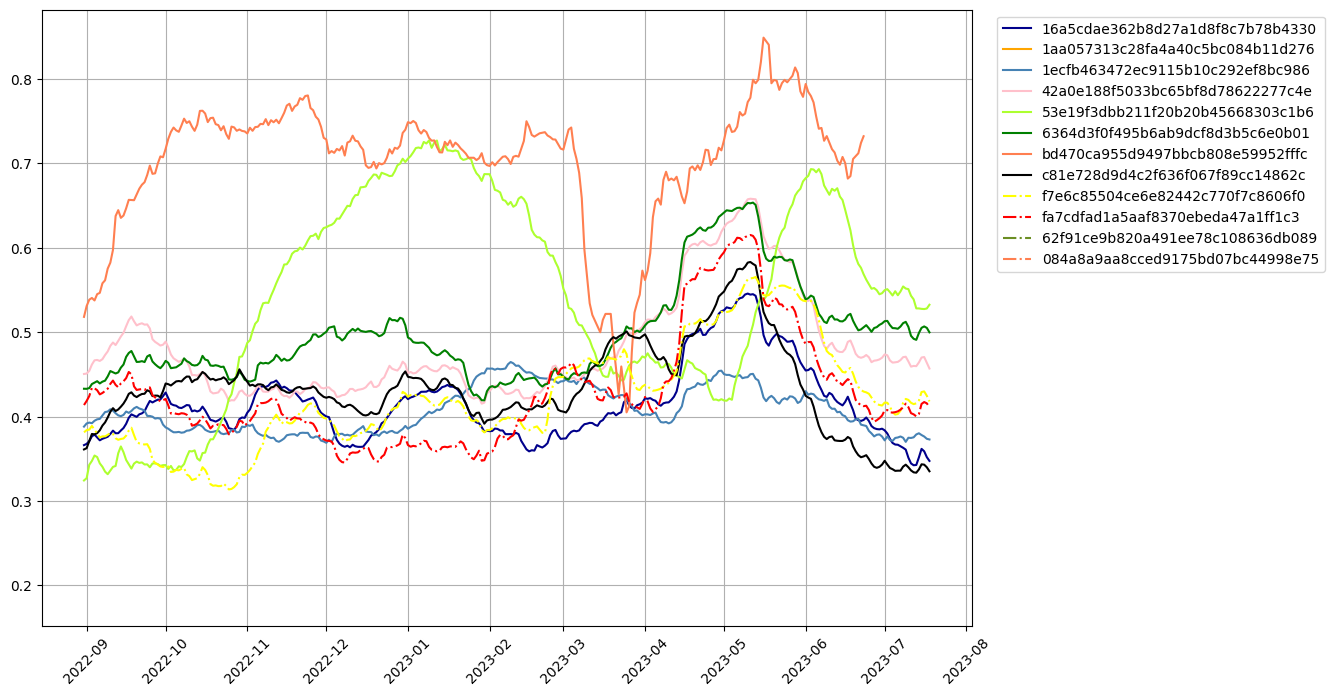

In [35]:
plt.figure(figsize=(12,8))
for gr_col in df_st_id['st_id'].unique():
    plt.plot(df_st_id.loc[df_st_id['st_id'] == gr_col, 'sale_ratio_rm_promo_to_non_promo'], label=gr_col)
plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left')
plt.grid()
plt.xticks(rotation=45)
plt.show()

По отношению количества проданных товаров по акции к количество товаров проданных без акции также выбиваются два магазина (они же имели и меньшее из скользящих средних. Также отличатеся динамика промоакций для магазина 1ecfb463472ec9115b10c292ef8bc986 (у него отсутствуют характерные пики в мае).

Для более глубокого анализа посмотрим датасет с информацией о магазинах

In [36]:
df_st = pd.read_csv(PATH_ST_DF)
df_st.head()

st_id                        st_city_id  \
0  1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
1  bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2  6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3  1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4  16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                   st_division_code  st_type_format_id  st_type_loc_id  \
0  81b4dd343f5880df806d4c5d4a846c64                  4               3   
1  e26072c92d8fe0738df44d571d5f5e8b                  4               3   
2  da742b3cfca5388aaf9af28a726a3c30                  1               1   
3  429a86ff6336c144ddaf6144f52ab52c                  2               1   
4  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

   st_type_size_id  st_is_active  
0               19             0  
1               19             1  
2               12             1  
3               28             1  
4                8             1

In [37]:
df_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [38]:
df_st.describe()

st_type_format_id  st_type_loc_id  st_type_size_id  st_is_active
count          12.000000       12.000000        12.000000     12.000000
mean            2.333333        1.916667        16.750000      0.833333
std             1.497473        0.996205         7.557356      0.389249
min             1.000000        1.000000         8.000000      0.000000
25%             1.000000        1.000000        12.000000      1.000000
50%             1.500000        1.500000        15.500000      1.000000
75%             4.000000        3.000000        19.250000      1.000000
max             4.000000        3.000000        32.000000      1.000000

В датасете информация по всем 12 магазинам изучим более подробно каждый столбец

Посмотрим сколько в каждом городе магазинов

In [39]:
df_st['st_city_id'].value_counts()

st_city_id
1587965fb4d4b5afe8428a4a024feb0d    2
955d864a62659945cc9434898e275deb    2
b8b4b727d6f5d1b61fff7be687f7970f    2
908c9a564a86426585b29f5335b619bc    2
3202111cf90e7c816a472aaceb72b0df    2
c1f75cc0f7fe269dd0fd9bd5e24f9586    1
885fe656777008c335ac96072a45be15    1
Name: count, dtype: int64

Срез достаточно равномерный за исключением двух городов в каждом городе предоставлены 2 магазина.

Чтобы лучше понять динамику спроса по магазинам объединим два датасета

In [40]:
sales_df_train = sales_df_train.merge(df_st, on='st_id')
sales_df_train.head()

st_id                         pr_sku_id  \
0  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
1  16a5cdae362b8d27a1d8f8c7b78b4330  0094042bfeae507dc7f62acc8e5ed03a   
2  16a5cdae362b8d27a1d8f8c7b78b4330  0094042bfeae507dc7f62acc8e5ed03a   
3  16a5cdae362b8d27a1d8f8c7b78b4330  033013f94a18c066e8b3d610bed34bee   
4  16a5cdae362b8d27a1d8f8c7b78b4330  04bbb07b1057b09d04209991f3eadd8f   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-08-01                 0                1.0                      0.0   
1 2022-08-01                 1                2.0                      2.0   
2 2022-08-01                 0                4.0                      0.0   
3 2022-08-01                 0                4.0                      0.0   
4 2022-08-01                 1                0.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub                        st_city_id  \
0            435.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
1            383.0                  383.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
2            712.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
3            102.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
4             85.0                   85.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                   st_division_code  st_type_format_id  st_type_loc_id  \
0  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
1  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
2  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
3  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   
4  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

   st_type_size_id  st_is_active  
0                8             1  
1                8             1  
2                8             1  
3                8             1  
4                8             1

Напишим функцию, которая будет заменять длиные столбцы названий на более короткие.

In [41]:
def rename_values (df, columns, first_part, drop_old=True):
    if df[columns].dtypes != 'int64':
        map_reanme = {x: f'{first_part}_{i}' for i, x in enumerate(df[columns].unique())}
    else:
        map_reanme = {i: f'{first_part}_{i}' for i in df[columns].unique()}
    df[f'new_{first_part}'] = df[columns].map(map_reanme)
    if drop_old:
        df = df.drop(columns, axis=1)
    return df

Создадим функцию, которая будет добавлять новый столбец по имени, получать скользящее среднее и строить график

In [42]:
def show_visualisation_new_col(df, column_name, name):
    df = rename_values(df, column_name, name)
    df['new_name'] = df[f'new_{name}'] + '_' + df['st_id']
    df_st_id = get_df_ts_store(df, 'new_name')
    df_st_id = get_rolling_mean(df_st_id, 'new_name', 'pr_sales_in_units')
    visualize_stores(df_st_id, 'new_name', 'rolling_mean_pr_sales_in_units')

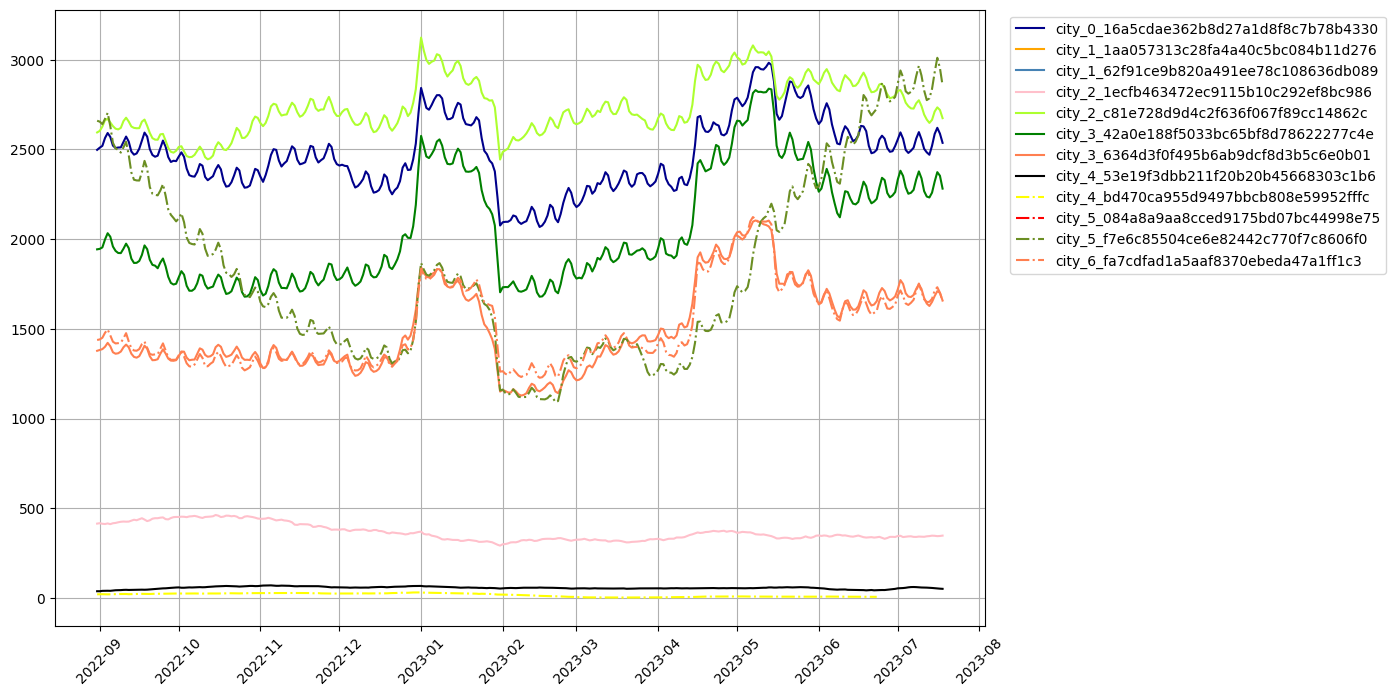

In [43]:
show_visualisation_new_col(sales_df_train, 'st_city_id', 'city')

По графику видно, что оба магазина с минимальными продажами находятся в городе 4, возможно это просто небольшой город, поэтому там такие низкие продажи. По остальным городам такая корреляция не наблюдается.

Изучим дивизионы.

In [44]:
df_st['st_division_code'].value_counts()

st_division_code
81b4dd343f5880df806d4c5d4a846c64    2
e26072c92d8fe0738df44d571d5f5e8b    2
da742b3cfca5388aaf9af28a726a3c30    2
429a86ff6336c144ddaf6144f52ab52c    2
296bd0cc6e735f9d7488ebc8fbc19130    2
32586311f16876abf92901085bd87b99    2
Name: count, dtype: int64

В каждом дивизионе предоставлено по 2 магазина аналогично построим график скользящего среднего по дивизионам.

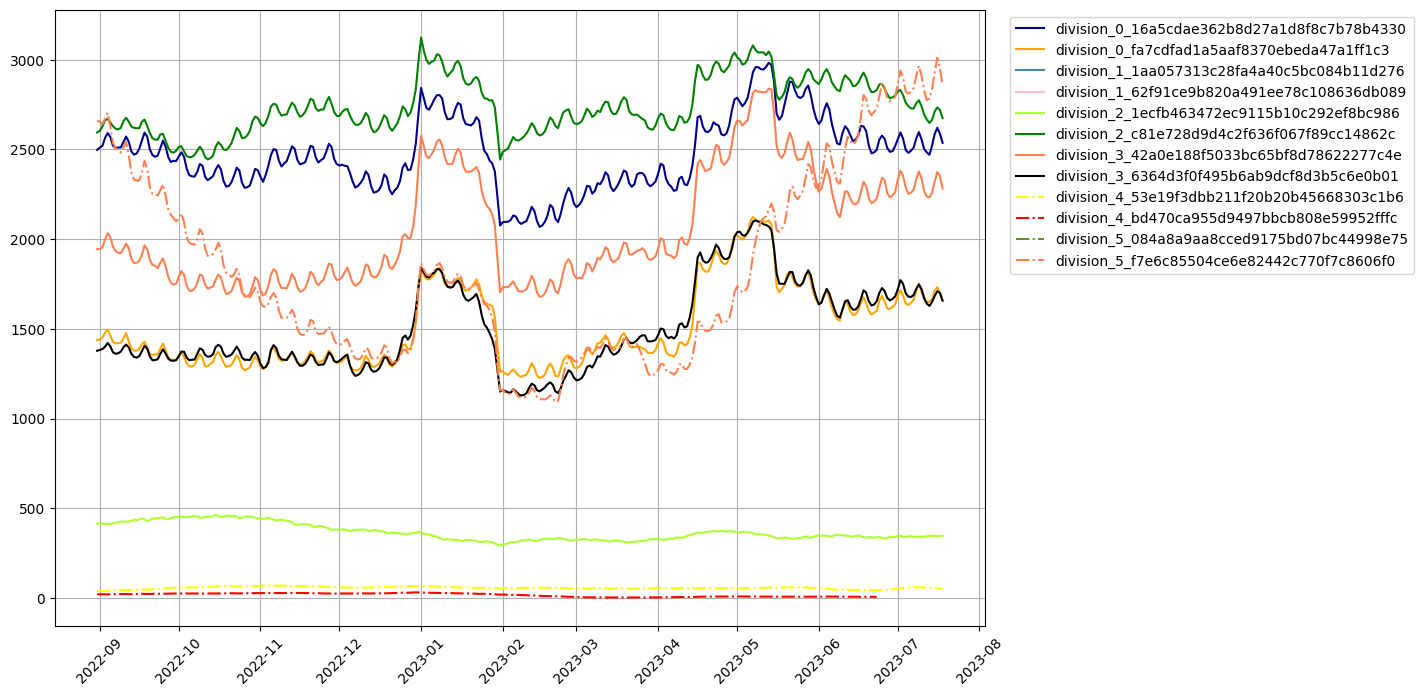

In [45]:
show_visualisation_new_col(sales_df_train, 'st_division_code', 'division')

Два магазина с самыми низкими продажами опять оказались в одном дивизионе

Посмотрим варианты формата магазинов

In [46]:
df_st['st_type_format_id'].value_counts()

st_type_format_id
1    6
4    5
2    1
Name: count, dtype: int64

Очень много магазинов формата 1 и только один магазин формата 2

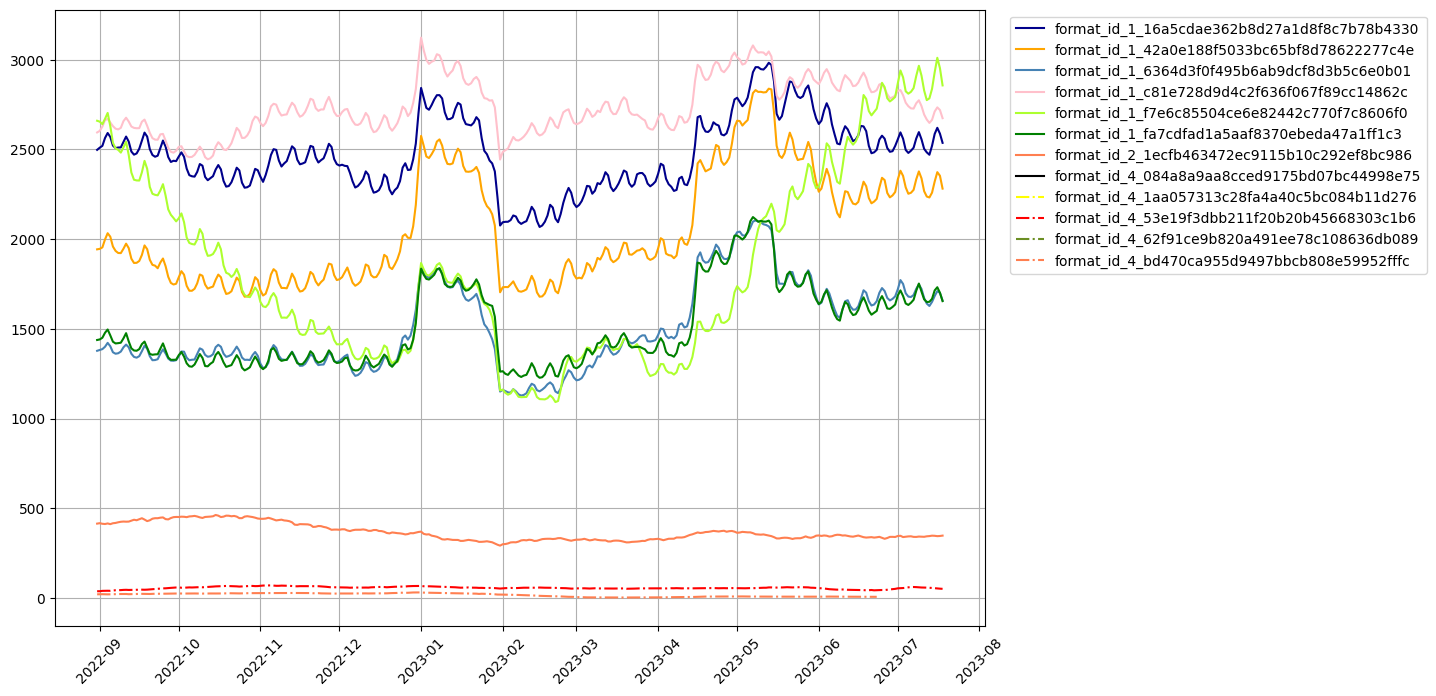

In [47]:
show_visualisation_new_col(sales_df_train, 'st_type_format_id', 'format_id')

Магазины с 1 типом формата в целом показывают более высокий уровень продаж, поэтому это нужно выделить в отдельный признак

Изучим варианты локации

In [48]:
df_st['st_type_loc_id'].value_counts()

st_type_loc_id
1    6
3    5
2    1
Name: count, dtype: int64

Схожие значения и по локации магазина. Возможно эти данные скоррелированны. проверим это.

In [49]:
df_st['st_type_format_id']. corr(df_st['st_type_loc_id'])

0.9344075086392242

Действительно данные этих столбцов сильно скоррелированы. Возможно стоит пойти от обратного и посмотреть как отличается поведение тех магазинов, которые не скоррелированы.

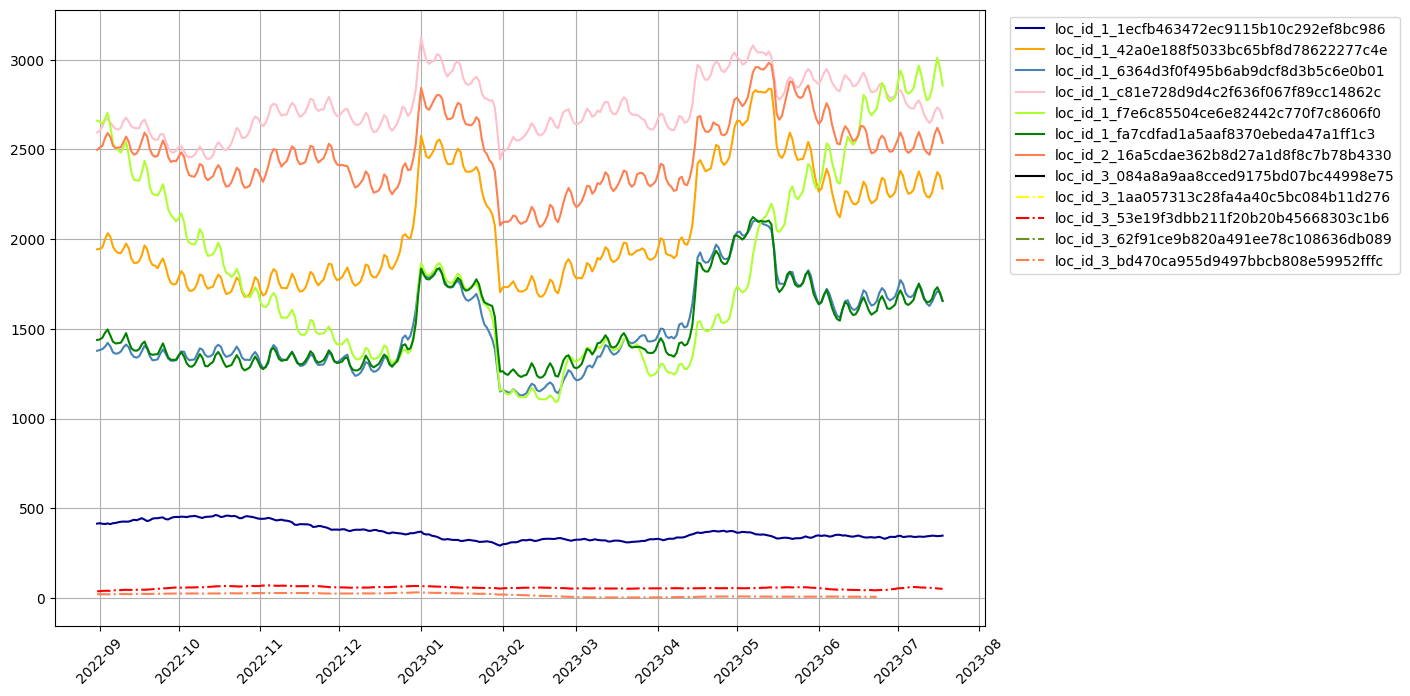

In [50]:
show_visualisation_new_col(sales_df_train, 'st_type_loc_id', 'loc_id')

По данным графикам стоит выделить 3 тип локаций, они имеют самый низкий уровень продаж.

Рассмотрим варианты типа размера магазина

In [51]:
df_st['st_type_size_id'].value_counts()

st_type_size_id
12    4
19    3
8     2
28    1
20    1
32    1
Name: count, dtype: int64

Типоразмеры магазинов распределены неравномерно

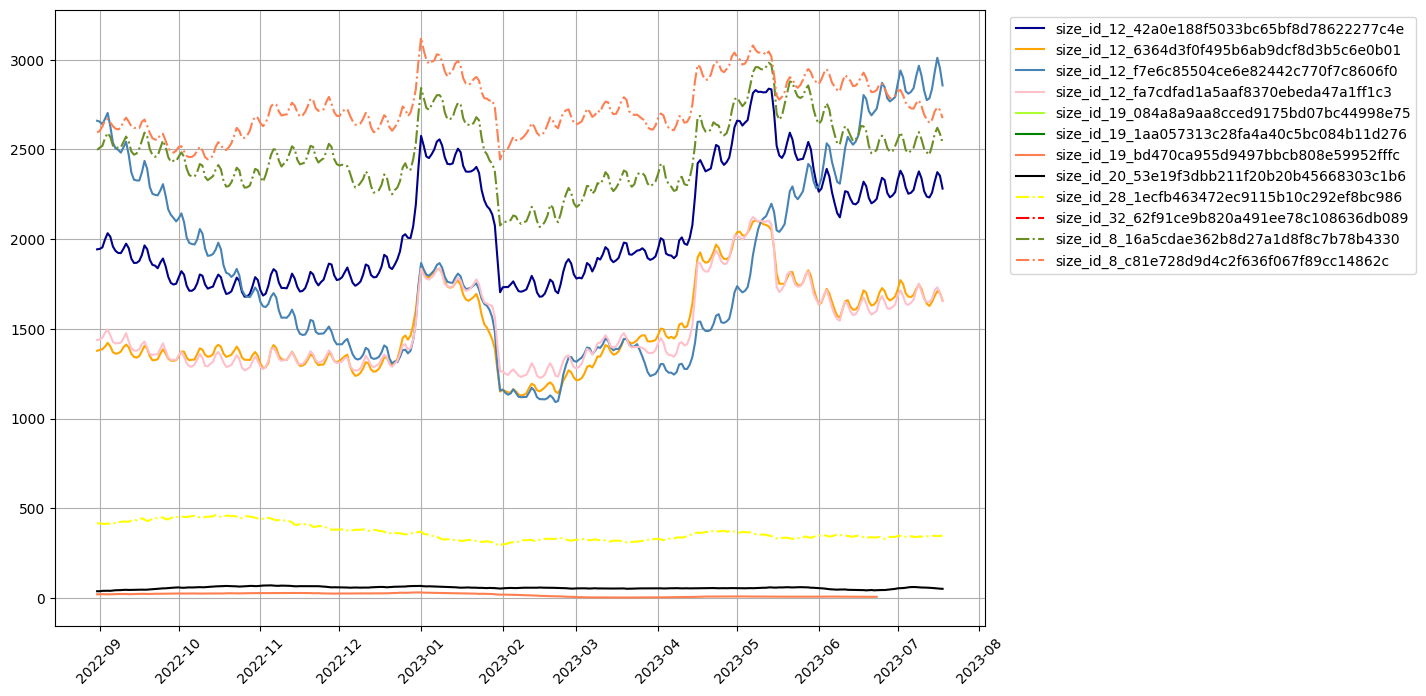

In [52]:
show_visualisation_new_col(sales_df_train, 'st_type_size_id', 'size_id')

8 типоразмер магазинов относится к топовым по продажам (вероятно это самые большие из них). 12 к середничкам, остальные к магазинам с низким уровнем продаж.

Посмотрим на флаг активного магазина

In [53]:
df_st['st_is_active'].value_counts()

st_is_active
1    10
0     2
Name: count, dtype: int64

У нас два закрытых магазина, при обучении их не будем учитывать. Выведем id этих магазинов

In [54]:
df_st[df_st['st_is_active']==0]

st_id                        st_city_id  \
0   1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
10  62f91ce9b820a491ee78c108636db089  1587965fb4d4b5afe8428a4a024feb0d   

                    st_division_code  st_type_format_id  st_type_loc_id  \
0   81b4dd343f5880df806d4c5d4a846c64                  4               3   
10  81b4dd343f5880df806d4c5d4a846c64                  4               3   

    st_type_size_id  st_is_active  
0                19             0  
10               32             0

По обоим магазином у нас и так слишком мало информации поэтому по ним не будем учить модели.

### Выводы

Для анализа была предоставлена ифнормация по 12 магазинам в целом по ним можно сделать следующие выводы:

1. Магазины отличают по количеству проданных товаров, и по динамике спроса, поэтому целесообрано будет обучить разные модели для разных типов магазинов. 
2. В данных есть 3 магазина, по которым слишком мало информации (предоставлены данные менее чем за 50 дат), при этом два из них закрылись, по ним нельзя будет обучить модель. Также по одному магазину есть пропуски и их нужно будет заполнять.
3. По отношению товаров проданных по промо и без него можно выделить следующие группы магазинов:
    * Магазины со средним значением меньше 2,5;
    * Магазины со средним значением от 2,5 до 4;
    * Магазины со средним значением от 4 до 5;
    * Магазины со средним значением свыше 5
4. При анализе скользящего среднего с окном в 30 дней было выявлено, что можно выделить 3 группы магазинов:
    * Магазины со скользящим средним ниже 500;
    * Магазины у которых наблюдается обратная сезонность (отношение скользящего среднего в июля к скользящему среднему в январе больше 1;
    * Остальные магазины  
По каждому типу данных магазинов будем обучать отдельную модель, поскольку динамика спроса у них отличается
5. При анализе городов и дивизионов выявлено, что  два магазина с низкими продажами находятся в одном и том же городе, с точки зрения обучения модели под текущую задачу, признаки мгоут оказаться сильными, но при дальнейшем масштабировании в проде, необходимо будет учесть, что это может быть ложным признаком и в этом дивизионе могут оказаться топовые магазины.
6. По формату магазина сильно выделяется формат 1 у него более высокие уровни продаж.
7. По локациям выделяется 3 тип локации, он наоборот имеет самый низкий уровень продаж.


**Обобщение:**

Для более качественного предсказания целесообразно обучить 3 модели с разделением по скользящему среднему в 30 дней:
* Магазины со скользящим средним ниже 500;
* Магазины у которых наблюдается обратная сезонность (отношение скользящего среднего в июля к скользящему среднему в январе больше 1;
* Остальные магазины.

В качестве признаков добавим:
* Скользящее среднее (миниму одно на 30 дней, также поэкспериментируем с другими диапазонами)
* Закодированное OnHotEncoder отношение проданных товаров по промо и без него с разделением по следующим группам:
    * Магазины со средним значением меньше 2,5;
    * Магазины со средним значением от 2,5 до 4;
    * Магазины со средним значением от 4 до 5;
    * Магазины со средним значением свыше 5
* Закодированное OnHotEncoder id Дивизиона и города (проверить качество модели если оставить только ливизион 4 и город 4(именно в них находятся магазины с самыми низкими продажами))
* Закодированные типы магазинов (проверить качество, если оставить только отметку для магазинов с форматом 1)
* Закодированные локации магазинов (проверить качество, если оставить только 3 тип локации)

In [55]:
del df_st_id, df_st, df_count_date

## Анализ товаров

In [56]:
df_pr = pd.read_csv(PATH_PR_DF)
df_pr.head()

pr_sku_id                       pr_group_id  \
0  fd064933250b0bfe4f926b867b0a5ec8  c74d97b01eae257e44aa9d5bade97baf   
1  71c9661741caf40a92a32d1cc8206c04  c74d97b01eae257e44aa9d5bade97baf   
2  00b72c2f01a1512cbb1d3f33319bac93  c74d97b01eae257e44aa9d5bade97baf   
3  9bc40cd2fe4f188f402bb41548c5e15c  c74d97b01eae257e44aa9d5bade97baf   
4  3a74a370c8eb032acb11ad9119242b8f  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
1  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   
2  1bc0249a6412ef49b07fe6f62e6dc8de  d407a3ebb4ab9b0d68b224486f8b8dad   
3  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
4  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   

   pr_uom_id  
0         17  
1         17  
2         17  
3         17  
4         17

pr_group_id – захэшированная группа товара;  
pr_cat_id – захэшированная категория товара;  
pr_subcat_id – захэшированная подкатегория товара;  
pr_sku_id – захэшированное id товара;  
pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).

Посмотрим на распределение товаров по группам

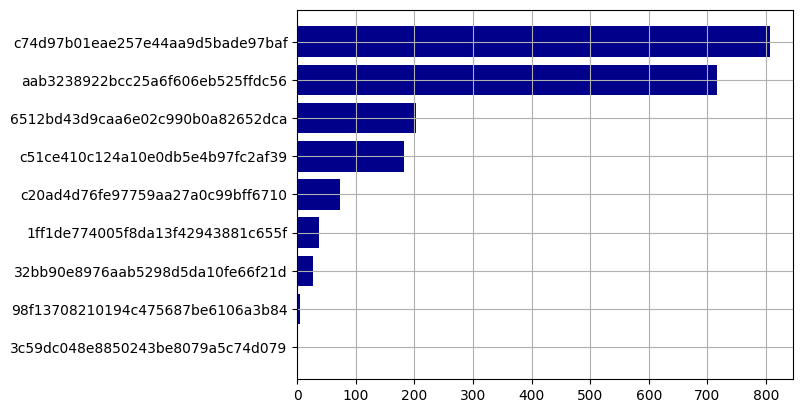

In [57]:
df_sku = (df_pr.groupby('pr_group_id')['pr_sku_id']
               .agg('count')
               .reset_index(drop=False)
               .sort_values('pr_sku_id'))
plt.barh(df_sku['pr_group_id'], df_sku['pr_sku_id'])
plt.grid()
plt.show()

Есть две группы товаров в котором больше всего разных товаров, также выделяются 5 групп в которых менее 100 товаров в каждой идве группы промежуточных товаров

Присоединим наш датасет к первоначальному и проанализируем его

In [58]:
sales_df_train = sales_df_train.merge(df_pr, on='pr_sku_id')
sales_df_train.head()

st_id                         pr_sku_id  \
0  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
1  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
2  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
3  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
4  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-08-01                 0                1.0                      0.0   
1 2022-08-02                 0                1.0                      0.0   
2 2022-08-03                 0                1.0                      0.0   
3 2022-08-12                 0                1.0                      0.0   
4 2022-08-13                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub                        st_city_id  \
0            435.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
1            394.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
2            304.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
3            150.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   
4            398.0                    0.0  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                   st_division_code  ...  st_is_active  new_city  \
0  296bd0cc6e735f9d7488ebc8fbc19130  ...             1    city_0   
1  296bd0cc6e735f9d7488ebc8fbc19130  ...             1    city_0   
2  296bd0cc6e735f9d7488ebc8fbc19130  ...             1    city_0   
3  296bd0cc6e735f9d7488ebc8fbc19130  ...             1    city_0   
4  296bd0cc6e735f9d7488ebc8fbc19130  ...             1    city_0   

   new_division  new_format_id new_loc_id new_size_id  \
0    division_0    format_id_1   loc_id_2   size_id_8   
1    division_0    format_id_1   loc_id_2   size_id_8   
2    division_0    format_id_1   loc_id_2   size_id_8   
3    division_0    format_id_1   loc_id_2   size_id_8   
4    division_0    format_id_1   loc_id_2   size_id_8   

                        pr_group_id                         pr_cat_id  \
0  aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   
1  aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   
2  aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   
3  aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   
4  aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   

                       pr_subcat_id pr_uom_id  
0  8afe22eeb3f3f68de994a3c60388858c         1  
1  8afe22eeb3f3f68de994a3c60388858c         1  
2  8afe22eeb3f3f68de994a3c60388858c         1  
3  8afe22eeb3f3f68de994a3c60388858c         1  
4  8afe22eeb3f3f68de994a3c60388858c         1  

[5 rows x 23 columns]

Напишим функцию для визуализации товаров

In [59]:
def visualize_sku(df, column):
    df_st_id = get_df_ts_store(df, column)
    df_st_id = get_rolling_mean(df_st_id, column, 'pr_sales_in_units')
    visualize_stores(df_st_id, column, 'rolling_mean_pr_sales_in_units')

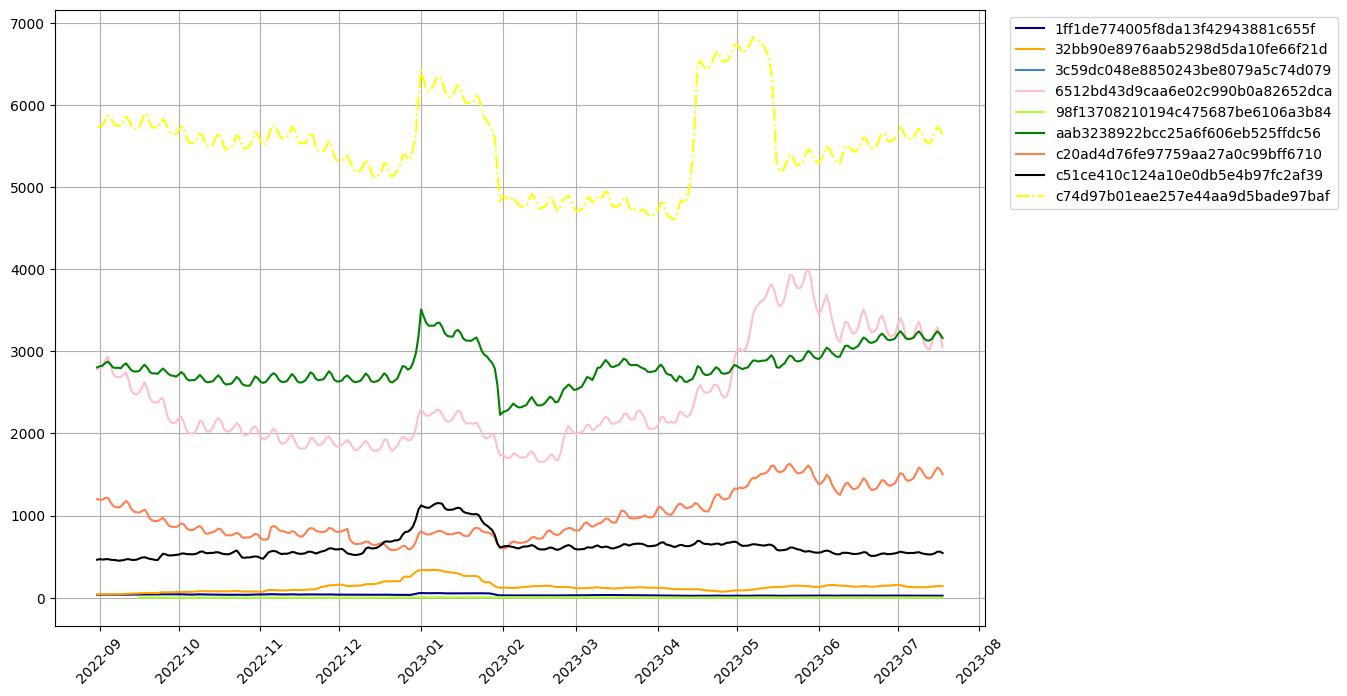

In [60]:
visualize_sku(sales_df_train, 'pr_group_id')

По группам товаро видно, что:
* группа c74d97b01eae257e44aa9d5bade97baf имеет сильный рост в период пасхи;
* группы 6512bd43d9caa6e02c990b0a82652dca и c20ad4d76fe97759aa27a0c99bff6710 растут летом и также имеют сильный рост в мае
* группа aab3238922bcc25a6f606eb525ffdc56 имеет рост на новый год и в мае
* группыc 51ce410c124a10e0db5e4b97fc2af39 и 32bb90e8976aab5298d5da10fe66f21d имеютт сильный рост в период нового года, а в остальное время достаточно стабильны
* оставшиеся группы достаточно стабильны в течении года

Посмотрим как распределены категории в группах товаров

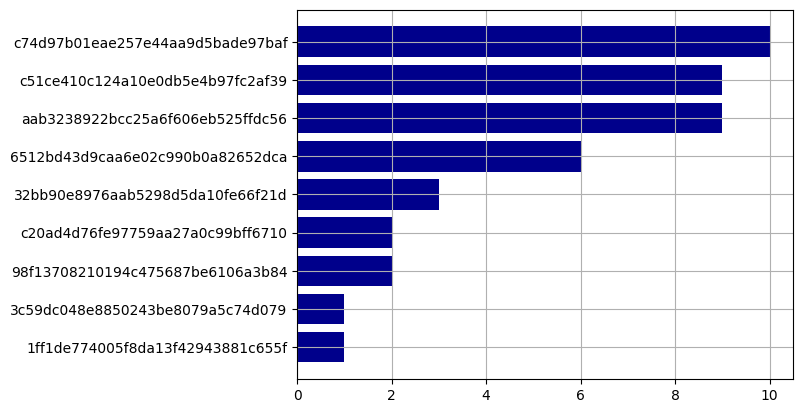

In [61]:
df_sku = (df_pr[['pr_group_id', 'pr_cat_id']]
               .drop_duplicates()
               .groupby('pr_group_id')['pr_cat_id']
               .agg('count')
               .reset_index(drop=False)
               .sort_values('pr_cat_id'))
plt.barh(df_sku['pr_group_id'], df_sku['pr_cat_id'])
plt.grid()
plt.show()

Разброс по категориям в группах от 1 до 10. Посмотрим как распределены товары по категориям

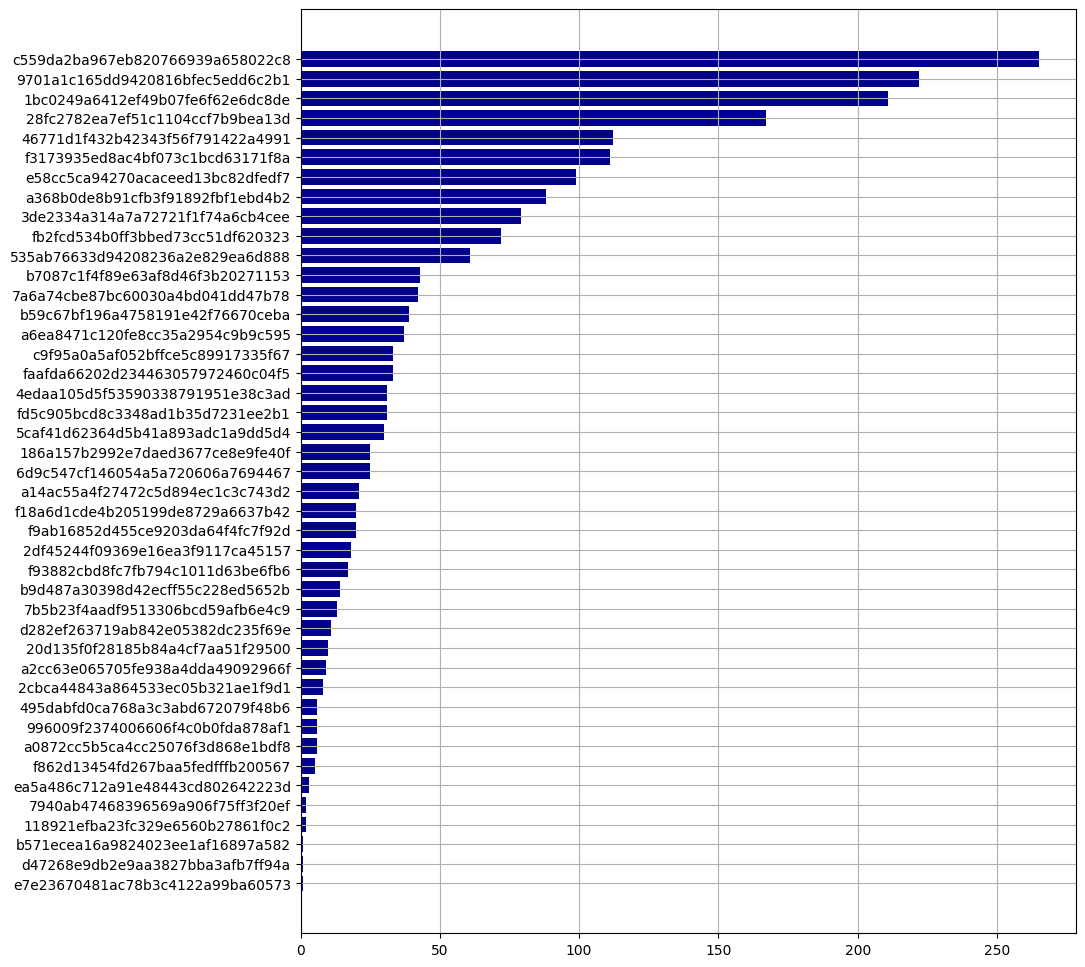

In [62]:
df_sku = (df_pr.groupby('pr_cat_id')['pr_sku_id']
               .agg('count')
               .reset_index(drop=False)
               .sort_values('pr_sku_id'))
plt.figure(figsize=(10, 12))
plt.barh(df_sku['pr_cat_id'], df_sku['pr_sku_id'])
plt.grid()
plt.show()

Наполнение категорий имеет большой разброс от одной до 270.

Построим графики скользящего среднего для категорий. Посоколько категорий много разобьём их по 12 штук на график

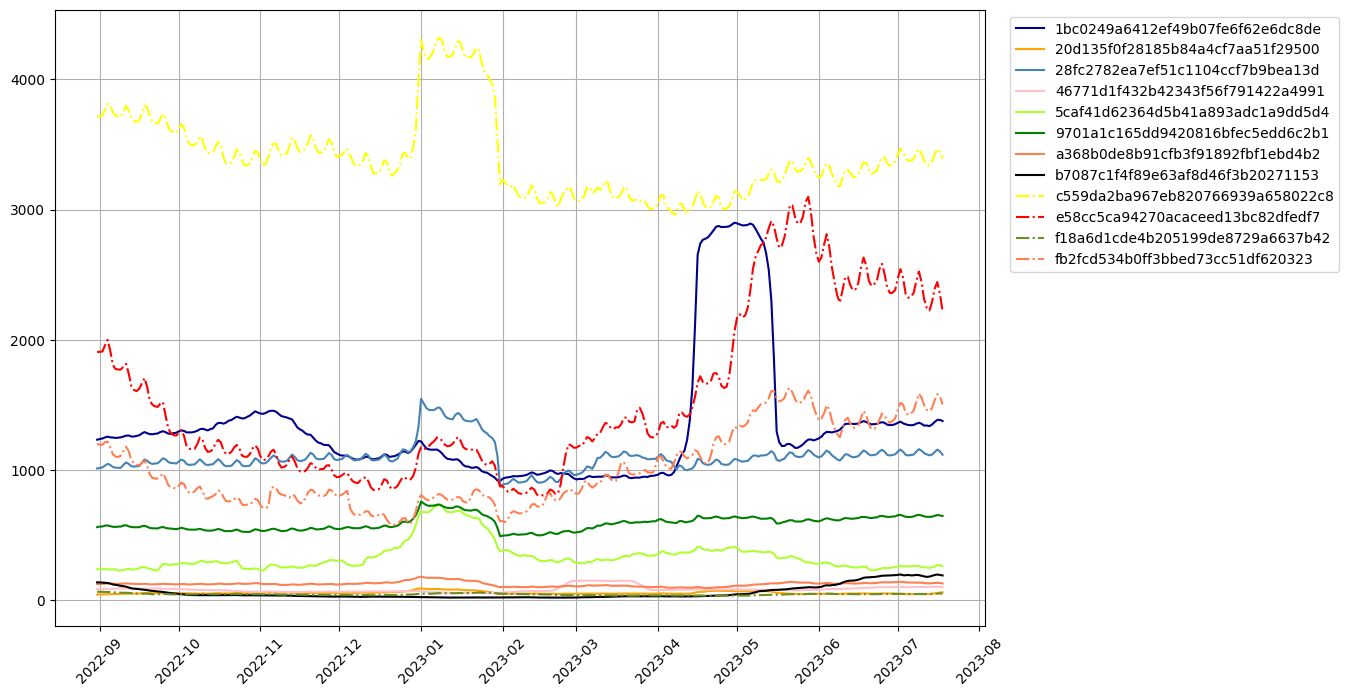

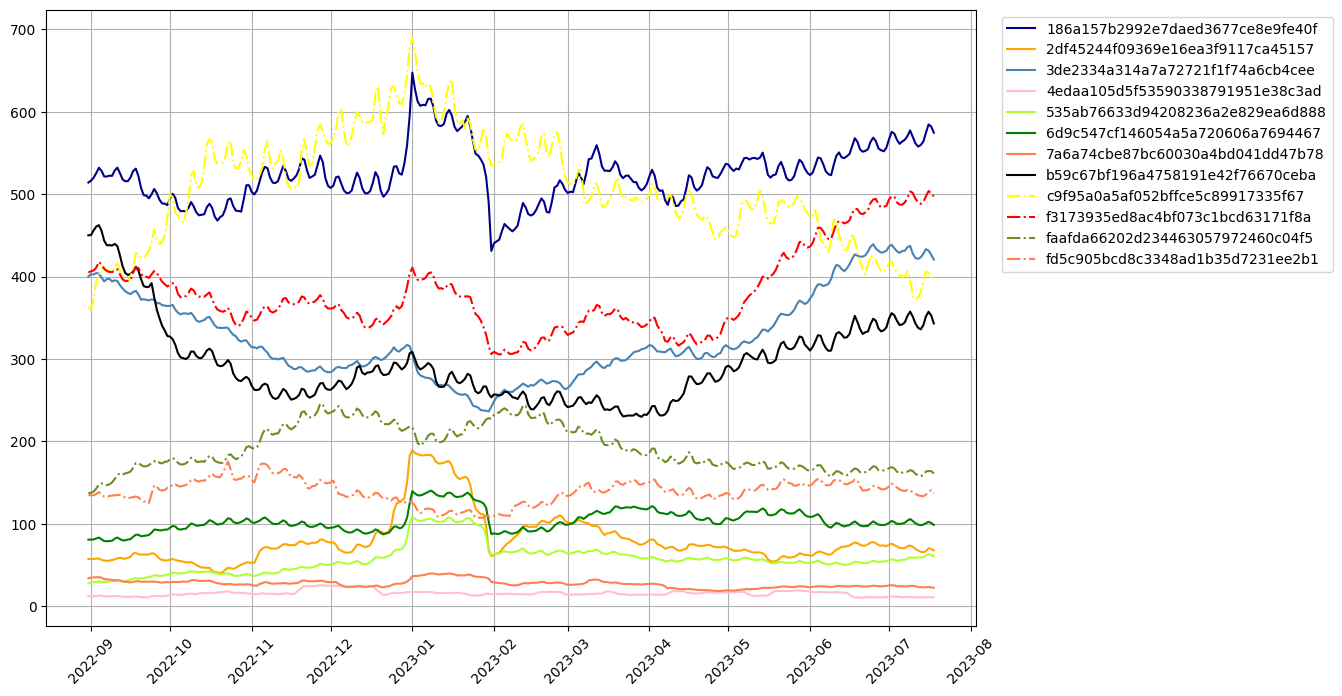

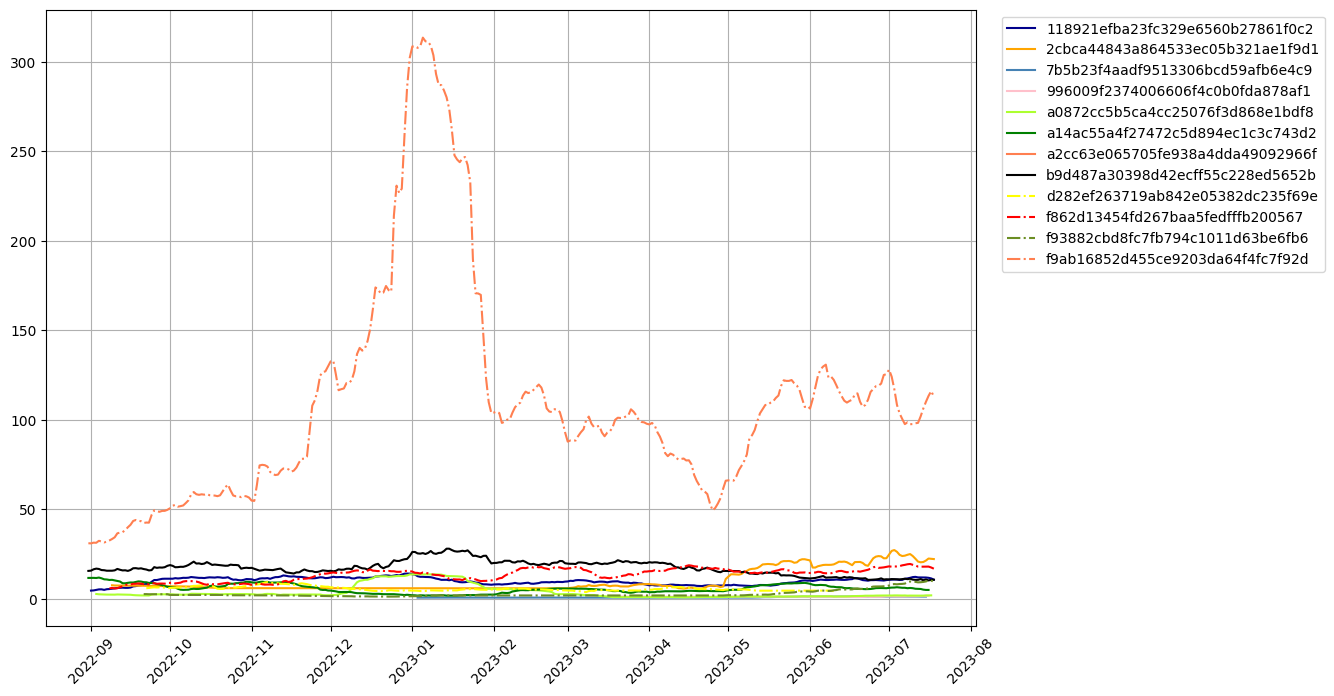

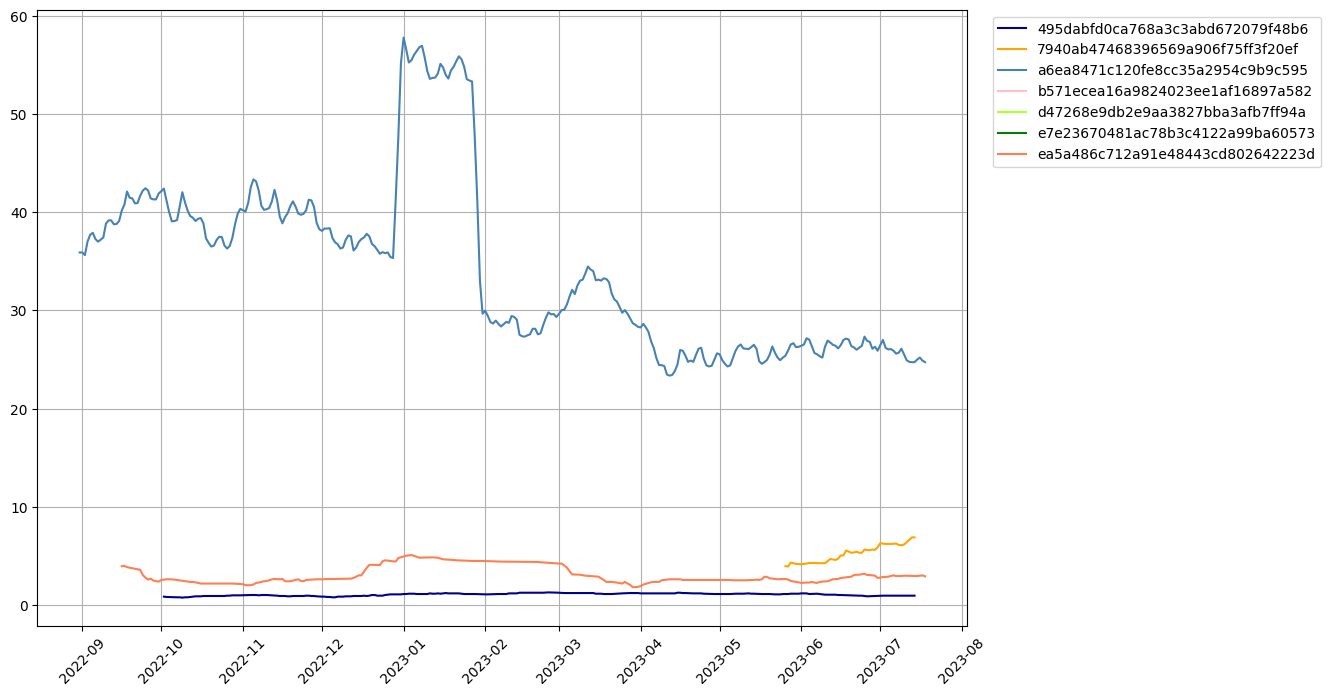

In [63]:
list_cat = sales_df_train['pr_cat_id'].unique()
for i in range(math.ceil(len(list_cat)/12)):
    list_cat_part = list_cat[i * 12 : (i + 1) * 12]
    df_for_visual = sales_df_train[sales_df_train['pr_cat_id'].isin(list_cat_part)]
    visualize_sku(df_for_visual, 'pr_cat_id')

Выводы по графикам: 
* категория c559da2ba967eb820766939a658022c8 у неё спрос значительно выше чем у других и в новый год наблюдается ярко выраженный максимум
* категория 1bc0249a6412ef49b07fe6f62e6dc8de имеет большой пик на пасху (возможно это выпечка и куличи, возможно какой-то другой продукт имеющий такой пик)
* категории e58cc5ca94270acaceed13bc82dfedf7, fb2fcd534b0ff3bbed73cc51df620323 имеют просадку зимой и рост в майские праздники и лето (возможно что-то для дачи или для отдыха на природе)
* категории 3de2334a314a7a72721f1f74a6cb4cee, f3173935ed8ac4bf073c1bcd63171f8a, b59c67bf196a4758191e42f76670ceba имеют просадку зимой и рост ближе клету, но при этом майские пики не настолько сильно выражены
* категории 28fc2782ea7ef51c1104ccf7b9bea13d, 9701a1c165dd9420816bfec5edd6c2b1, 5caf41d62364d5b41a893adc1a9dd5d4, 186a157b2992e7daed3677ce8e9fe40f, 2df45244f09369e16ea3f9117ca45157, 6d9c547cf146054a5a720606a7694467, 535ab76633d94208236a2e829ea6d888, a6ea8471c120fe8cc35a2954c9b9c595 имеют весьма ровное распределение с пиком в новый год хотя и отличаются масштабом
* категория f9ab16852d455ce9203da64f4fc7f92d имеет достаточно низкий спрос в течении года и пик на новый год
* категории b7087c1f4f89e63af8d46f3b20271153, f93882cbd8fc7fb794c1011d63be6fb6 имеют рост продаж только летом
* категория faafda66202d234463057972460c04f5 имеет рост в декабре и феврале и падение в начале января
* категория fd5c905bcd8c3348ad1b35d7231ee2b1 достаточно стабильна, но просаживается в январе и феврале
* категория c9f95a0a5af052bffce5c89917335f67 плавно растёт в течении года по мере приближения января и затем плавно снижается к лету
* остальны категории достаточно стабильны будем их рассматривать как единую группу

Также по графикам видно, что некоторые категории товары продавались не весь год. Это могут как новые товары, так и сезонные. Это нужно будет учесть при обучении модели.

Рассмотрим более подробно категорию 1bc0249a6412ef49b07fe6f62e6dc8de, поскольку только она имеет пик в апреле, и есть вероятность что данный пик характерен не для всей категории, посмотрим на подкатегории этих товаров в данной категории

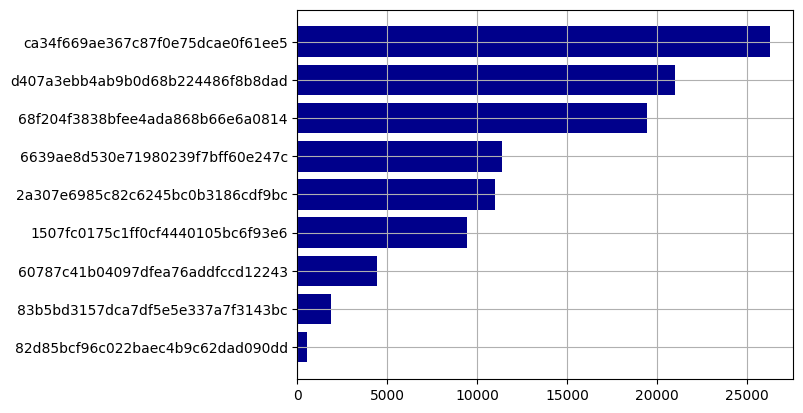

In [64]:
df = sales_df_train[sales_df_train['pr_cat_id']=='1bc0249a6412ef49b07fe6f62e6dc8de']
df_sku = (df.groupby('pr_subcat_id')['pr_sku_id']
               .agg('count')
               .reset_index(drop=False)
               .sort_values('pr_sku_id'))
plt.barh(df_sku['pr_subcat_id'], df_sku['pr_sku_id'])
plt.grid()
plt.show()

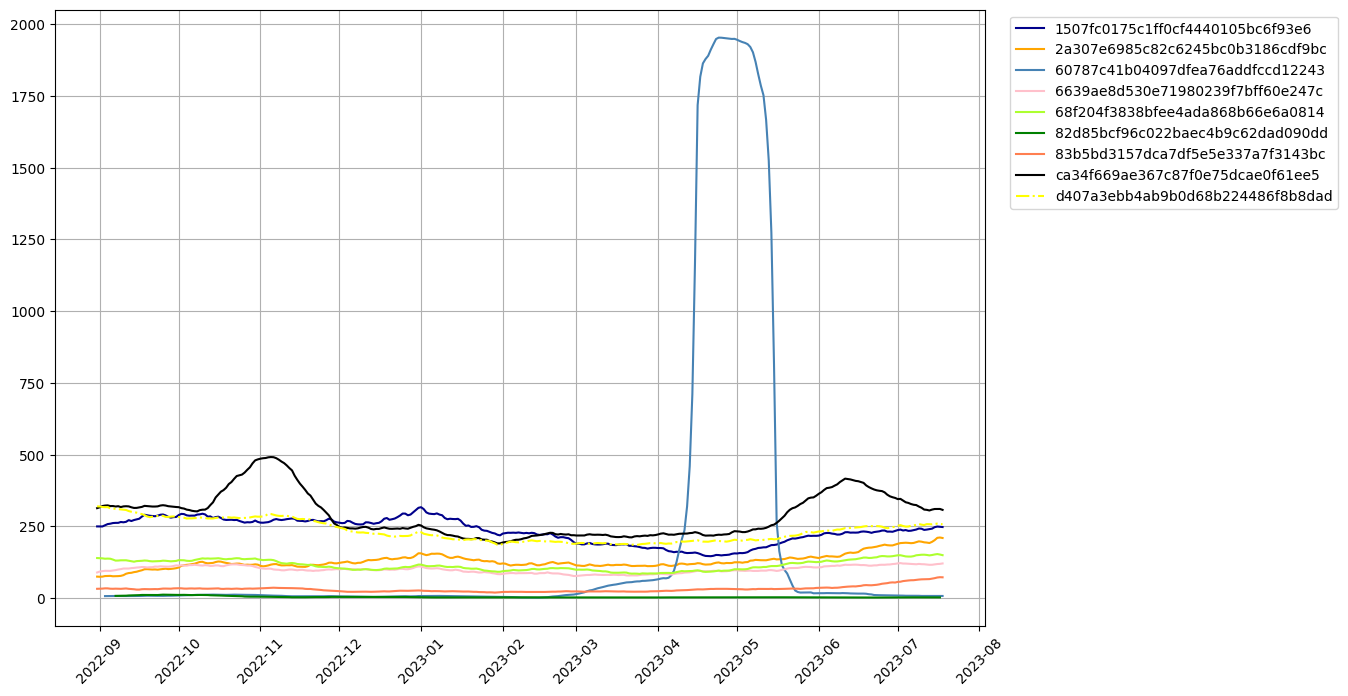

In [65]:
visualize_sku(sales_df_train[sales_df_train['pr_cat_id']=='1bc0249a6412ef49b07fe6f62e6dc8de'], 'pr_subcat_id')

Наше предположение, что пик в апреле характерен для отдной подкатегории товаров оказалось верно кроме этого также можно отметить, что за исключением ещё одного графика остальные имеют достаточно равномерное распеделение, поэтому:
* выделяем подкатегорию 60787c41b04097dfea76addfccd12243
* выделяем подкатегорию ca34f669ae367c87f0e75dcae0f61ee5
* остальные отнесём к группе с равномерным рспределением

На более низкий уровень спускаться не будем. Однако, как писалось Выше необходимо посмотреть какие категории товаров продаются слишком редко

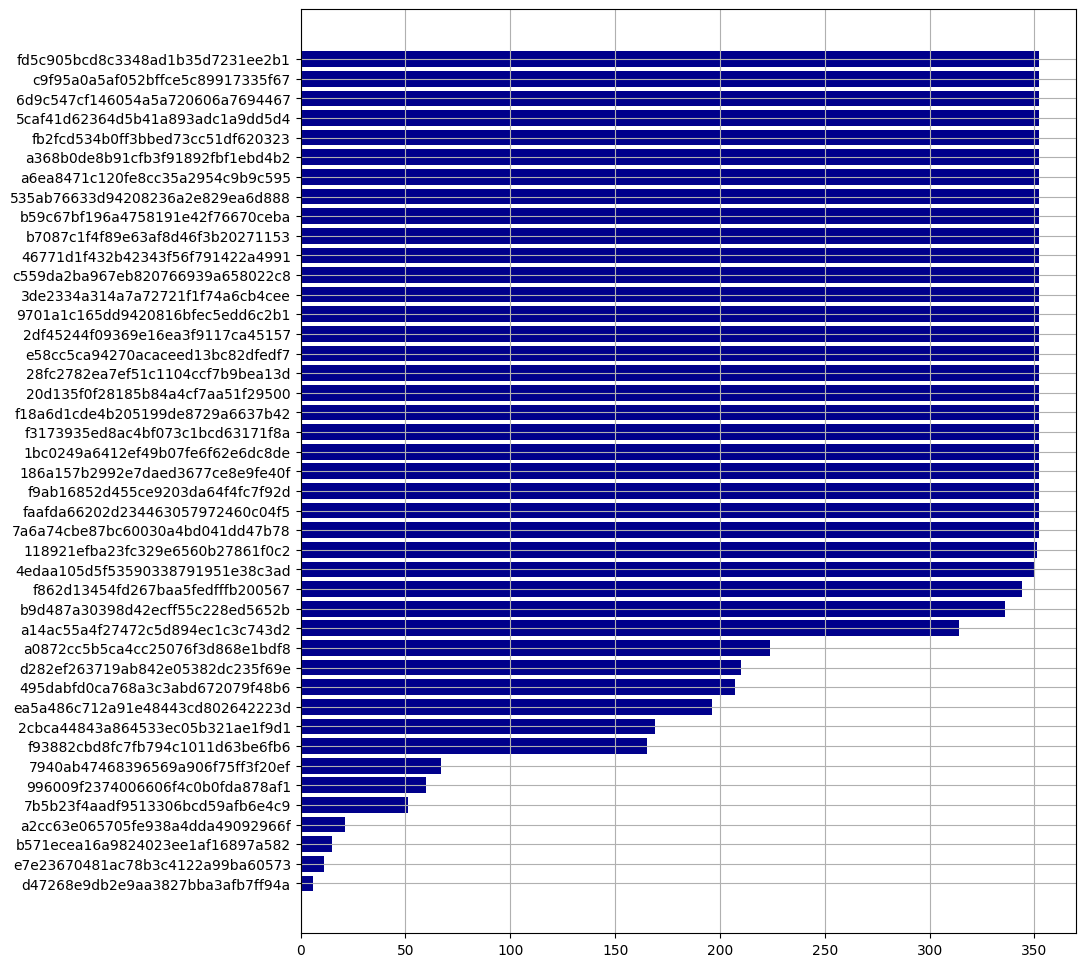

In [66]:
df_count_cat = (sales_df_train[['date', 'pr_cat_id']]
                 .drop_duplicates()
                 .groupby('pr_cat_id')
                 .agg('count')
                 .reset_index(drop=False)
                 .sort_values(by='date'))
plt.figure(figsize=(10, 12))
plt.barh(df_count_cat['pr_cat_id'], df_count_cat['date'])
plt.grid()
plt.show()

Посмотрим на категории, которые имеют меньше 250 дат

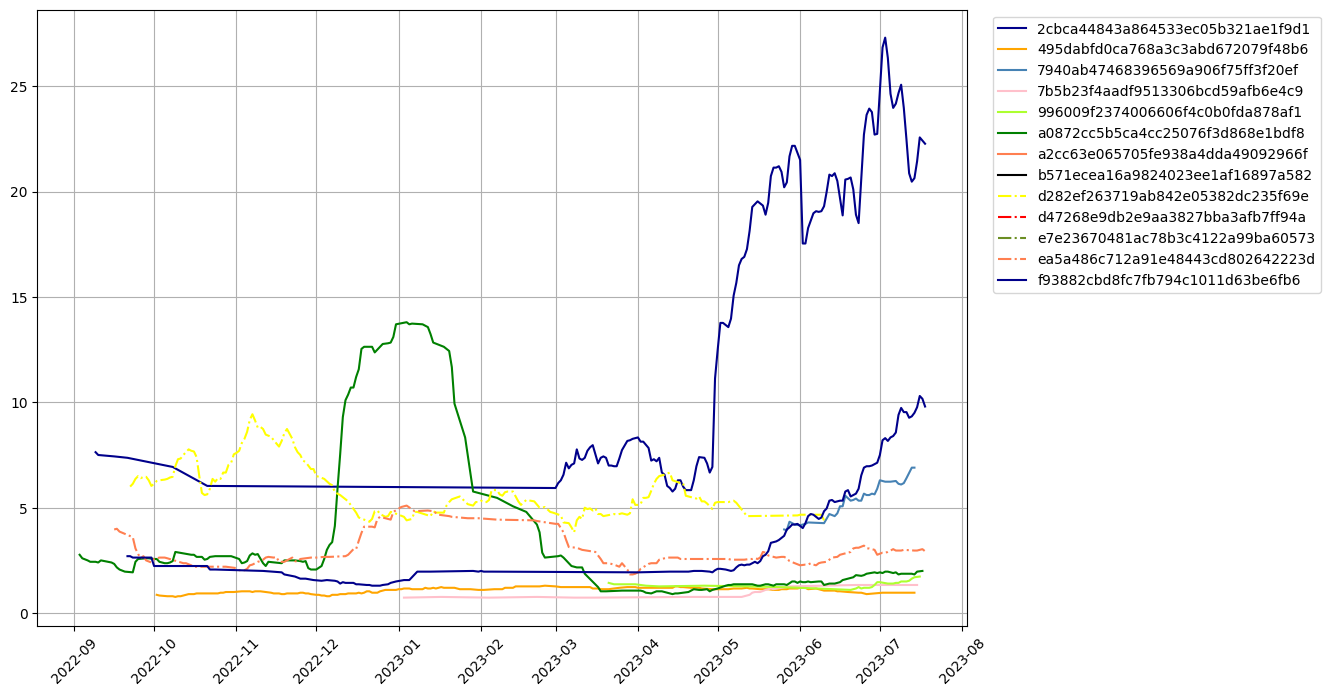

In [67]:
df_for_visual = sales_df_train[sales_df_train['pr_cat_id'].isin(df_count_cat[df_count_cat['date'] < 250]['pr_cat_id'])]
visualize_sku(df_for_visual, 'pr_cat_id')

Как видим, в большинстве своём это новые категории товаров и информация по ним идёт не с самого начала, при этом продажи по ним весьма низкие, однако есть категории товаров с продолжительностью меньше 100 дней, их придётся убрать, поскольку по ним недостаточно данных для создания полноценного прогноза. Также есть категория d282ef263719ab842e05382dc235f69e информация по которой начинается в середине октября и заканчивается в июне, её тоже не получится использовать для обучения.

In [68]:
del df_pr, df, df_for_visual, df_count_cat, sales_df_train

### Выводы

Была проанализированна информация по товарам, в ходе анализа было установлено:

1. По группам товаров видно, что:
   * группа c74d97b01eae257e44aa9d5bade97baf имеет сильный рост в период пасхи;
   * группы 6512bd43d9caa6e02c990b0a82652dca и c20ad4d76fe97759aa27a0c99bff6710 растут летом и также имеют сильный рост в мае
   * группа aab3238922bcc25a6f606eb525ffdc56 имеет рост на новый год и в мае
   * группыc 51ce410c124a10e0db5e4b97fc2af39 и 32bb90e8976aab5298d5da10fe66f21d имеютт сильный рост в период нового года, а в остальное время достаточно стабильны
   * оставшиеся группы достаточно стабильны в течении года
2. По категориям:
    * категория c559da2ba967eb820766939a658022c8 у неё спрос значительно выше чем у других и в новый год наблюдается ярко выраженный максимум
    * категория 1bc0249a6412ef49b07fe6f62e6dc8de имеет большой пик на пасху (возможно это выпечка и куличи, возможно какой-то другой продукт имеющий такой пик)
    * категории e58cc5ca94270acaceed13bc82dfedf7, fb2fcd534b0ff3bbed73cc51df620323 имеют просадку зимой и рост в майские праздники и лето (возможно что-то для дачи или для отдыха на природе)
    * категории 3de2334a314a7a72721f1f74a6cb4cee, f3173935ed8ac4bf073c1bcd63171f8a, b59c67bf196a4758191e42f76670ceba имеют просадку зимой и рост ближе клету, но при этом майские пики не настолько сильно выражены
    * категории 28fc2782ea7ef51c1104ccf7b9bea13d, 9701a1c165dd9420816bfec5edd6c2b1, 5caf41d62364d5b41a893adc1a9dd5d4, 186a157b2992e7daed3677ce8e9fe40f, 2df45244f09369e16ea3f9117ca45157, 6d9c547cf146054a5a720606a7694467, 535ab76633d94208236a2e829ea6d888, a6ea8471c120fe8cc35a2954c9b9c595 имеют весьма ровное распределение с пиком в новый год хотя и отличаются масштабом
    * категория f9ab16852d455ce9203da64f4fc7f92d имеет достаточно низкий спрос в течении года и пик на новый год
    * категории b7087c1f4f89e63af8d46f3b20271153, f93882cbd8fc7fb794c1011d63be6fb6 имеют рост продаж только летом
    * категория faafda66202d234463057972460c04f5 имеет рост в декабре и феврале и падение в начале января
    * категория fd5c905bcd8c3348ad1b35d7231ee2b1 достаточно стабильна, но просаживается в январе и феврале
    * категория c9f95a0a5af052bffce5c89917335f67 плавно растёт в течении года по мере приближения января и затем плавно снижается к лету
    * остальны категории достаточно стабильны будем их рассматривать как единую группу
3. Отдельный анализ категории 1bc0249a6412ef49b07fe6f62e6dc8de показал, что
    * пик в апреле характерен для подкатегории 60787c41b04097dfea76addfccd12243
    * остальные подкатегории, кроме ca34f669ae367c87f0e75dcae0f61ee5 имеют достаточно равномерное распределение, поэтому её также выведем отдельно
    * оставшиеся подкатегории отнесём к группе с равномерным рспределением
4. Также был проведён анализ категорий по периоду вхождений информации и было принято решение не рассматривать категории с продолжительностью менее 100 дней (это совсем новые товары по которым не понятна динамика. Кроме того для категории d282ef263719ab842e05382dc235f69e есть информация за период осень-начало лета, поэтому её мы тоже рассматривать не будем.     

**Обобщение:**

* В ходе анализа было установлено, что разные категории товаров имеют разное распределение, поэтому согласно разделим модели согласно п.2, при этом необходимо учесть, что для товаров из категории 1bc0249a6412ef49b07fe6f62e6dc8de модели будут разделяться согласно п.3, поскольку поведение подкатегорий внутри данной категории разнится.
* при подготовке признаков данные о категориях, по которым присутсвует менее 100 дат учитываться не будут.

## Общие выводы по разделу

В данном разделе был проведён первичный анализ данных, а также предложена стратегия предобработки данных и подход к созданию модели.

**Общий анализ:**

*Анализ продаж:*
1. Даные предоставлены в срезе с 2022-08-01 по 2023-07-18.
2. В данных наблюдается недельная сезонность с пиками в выходные дни.
3. Также наблюдаются пики в дни государственных праздников РФ.
4. Есть 2 больших пика по продажам 31 декабря (в связи с новым годом) и 15 апреля (предположительно связан с православной пасхой). При этом после этих пиков наблюдается спад продаж.

*Анализ магазинов:*
1. Для анализа были предоставлены данные по 12 магазинам.
2. Магазины отличают по количеству проданных товаров, и по динамике спроса, поэтому целесообрано будет обучить разные модели для разных типов магазинов. 
3. В данных есть 3 магазина, по которым слишком мало информации (предоставлены данные менее чем за 50 дат), при этом два из них закрылись, по ним нельзя будет обучить модель. Также по одному магазину есть пропуски и их нужно будет заполнять.
4. По отношению товаров проданных по промо и без него можно выделить следующие группы магазинов:
    * Магазины со средним значением меньше 2,5;
    * Магазины со средним значением от 2,5 до 4;
    * Магазины со средним значением от 4 до 5;
    * Магазины со средним значением свыше 5
5. При анализе скользящего среднего с окном в 30 дней было выявлено, что можно выделить 3 группы магазинов:
    * Магазины со скользящим средним ниже 500;
    * Магазины у которых наблюдается обратная сезонность (отношение скользящего среднего в июля к скользящему среднему в январе больше 1;
    * Остальные магазины  
По каждому типу данных магазинов будем обучать отдельную модель, поскольку динамика спроса у них отличается
6. При анализе городов и дивизионов выявлено, что  два магазина с низкими продажами находятся в одном и том же городе, с точки зрения обучения модели под текущую задачу, признаки мгоут оказаться сильными, но при дальнейшем масштабировании в проде, необходимо будет учесть, что это может быть ложным признаком и в этом дивизионе могут оказаться топовые магазины.
7. По формату магазина сильно выделяется формат 1 у него более высокие уровни продаж.
8. По локациям выделяется 3 тип локации, он наоборот имеет самый низкий уровень продаж.

*Анализ товаров*
1. По группам товаров видно, что:
   * группа c74d97b01eae257e44aa9d5bade97baf имеет сильный рост в период пасхи;
   * группы 6512bd43d9caa6e02c990b0a82652dca и c20ad4d76fe97759aa27a0c99bff6710 растут летом и также имеют сильный рост в мае
   * группа aab3238922bcc25a6f606eb525ffdc56 имеет рост на новый год и в мае
   * группыc 51ce410c124a10e0db5e4b97fc2af39 и 32bb90e8976aab5298d5da10fe66f21d имеютт сильный рост в период нового года, а в остальное время достаточно стабильны
   * оставшиеся группы достаточно стабильны в течении года
2. По категориям:
    * категория c559da2ba967eb820766939a658022c8 у неё спрос значительно выше чем у других и в новый год наблюдается ярко выраженный максимум
    * категория 1bc0249a6412ef49b07fe6f62e6dc8de имеет большой пик на пасху (возможно это выпечка и куличи, возможно какой-то другой продукт имеющий такой пик)
    * категории e58cc5ca94270acaceed13bc82dfedf7, fb2fcd534b0ff3bbed73cc51df620323 имеют просадку зимой и рост в майские праздники и лето (возможно что-то для дачи или для отдыха на природе)
    * категории 3de2334a314a7a72721f1f74a6cb4cee, f3173935ed8ac4bf073c1bcd63171f8a, b59c67bf196a4758191e42f76670ceba имеют просадку зимой и рост ближе клету, но при этом майские пики не настолько сильно выражены
    * категории 28fc2782ea7ef51c1104ccf7b9bea13d, 9701a1c165dd9420816bfec5edd6c2b1, 5caf41d62364d5b41a893adc1a9dd5d4, 186a157b2992e7daed3677ce8e9fe40f, 2df45244f09369e16ea3f9117ca45157, 6d9c547cf146054a5a720606a7694467, 535ab76633d94208236a2e829ea6d888, a6ea8471c120fe8cc35a2954c9b9c595 имеют весьма ровное распределение с пиком в новый год хотя и отличаются масштабом
    * категория f9ab16852d455ce9203da64f4fc7f92d имеет достаточно низкий спрос в течении года и пик на новый год
    * категории b7087c1f4f89e63af8d46f3b20271153, f93882cbd8fc7fb794c1011d63be6fb6 имеют рост продаж только летом
    * категория faafda66202d234463057972460c04f5 имеет рост в декабре и феврале и падение в начале января
    * категория fd5c905bcd8c3348ad1b35d7231ee2b1 достаточно стабильна, но просаживается в январе и феврале
    * категория c9f95a0a5af052bffce5c89917335f67 плавно растёт в течении года по мере приближения января и затем плавно снижается к лету
    * остальны категории достаточно стабильны будем их рассматривать как единую группу
3. Отдельный анализ категории 1bc0249a6412ef49b07fe6f62e6dc8de показал, что
    * пик в апреле характерен для подкатегории 60787c41b04097dfea76addfccd12243
    * остальные подкатегории, кроме ca34f669ae367c87f0e75dcae0f61ee5 имеют достаточно равномерное распределение, поэтому её также выведем отдельно
    * оставшиеся подкатегории отнесём к группе с равномерным рспределением
4. Также был проведён анализ категорий по периоду вхождений информации и было принято решение не рассматривать категории с продолжительностью менее 100 дней (это совсем новые товары по которым не понятна динамика. Кроме того для категории d282ef263719ab842e05382dc235f69e есть информация за период осень-начало лета, поэтому её мы тоже рассматривать не будем.

**Общие рекомендации к модели:**
1. Исходя из анализа магазинов целесообразно разделить 3 модели по скользящему среднему в 30 дней:
* Магазины со скользящим средним ниже 500;
* Магазины у которых наблюдается обратная сезонность (отношение скользящего среднего в июля к скользящему среднему в январе больше 1;
* Остальные магазины.
2. Исходя из анализа товаров целесообразно разделить модели в зависмости от отнесения к той или иной категории товаров:
* категория c559da2ba967eb820766939a658022c8 
* подкатегория 60787c41b04097dfea76addfccd12243 категории 1bc0249a6412ef49b07fe6f62e6dc8de 
* подкатегория ca34f669ae367c87f0e75dcae0f61ee5 категории 1bc0249a6412ef49b07fe6f62e6dc8de 
* категории e58cc5ca94270acaceed13bc82dfedf7, fb2fcd534b0ff3bbed73cc51df620323
* категории 3de2334a314a7a72721f1f74a6cb4cee, f3173935ed8ac4bf073c1bcd63171f8a, b59c67bf196a4758191e42f76670ceba 
* категории 28fc2782ea7ef51c1104ccf7b9bea13d, 9701a1c165dd9420816bfec5edd6c2b1, 5caf41d62364d5b41a893adc1a9dd5d4, 186a157b2992e7daed3677ce8e9fe40f, 2df45244f09369e16ea3f9117ca45157, 6d9c547cf146054a5a720606a7694467, 535ab76633d94208236a2e829ea6d888, a6ea8471c120fe8cc35a2954c9b9c595
* категория f9ab16852d455ce9203da64f4fc7f92d
* категории b7087c1f4f89e63af8d46f3b20271153, f93882cbd8fc7fb794c1011d63be6fb6
* категория faafda66202d234463057972460c04f5
* категория fd5c905bcd8c3348ad1b35d7231ee2b1
* категория c9f95a0a5af052bffce5c89917335f67 
* остальны категории достаточно стабильны будем их рассматривать как единую группу
*Итого получается 36 разных моделей*

**Общие рекомендации к признакам**
1. На основе анализа продаж было принято решение добавить следующие признаки:
* лаги в неделю, плюс посмотреть, возможно лучше себя покажет среднее из лагов 6 - 8 дней, поскольку сезонность иногда сжимается.
* флаг буднего / выходного дня
* день недели (закодировать через OneHotEncoder
* флаг государственных праздников РФ
* флаг нового года и пасхи
* флаг, что это неделя идёт после нового года и пасхи
* в выходных днях учесть переносы праздников (посмотреть постановления правительства о переносах на 2022, 2023 год)
2. На основе анализа магазинов:
* Скользящее среднее (миниму одно на 30 дней, также поэкспериментируем с другими диапазонами)
* Закодированное OnHotEncoder отношение проданных товаров по промо и без него с разделением по следующим группам:
    * Магазины со средним значением меньше 2,5;
    * Магазины со средним значением от 2,5 до 4;
    * Магазины со средним значением от 4 до 5;
    * Магазины со средним значением свыше 5
* Закодированное OnHotEncoder id Дивизиона и города (проверить качество модели если оставить только ливизион 4 и город 4(именно в них находятся магазины с самыми низкими продажами))
* Закодированные типы магазинов (проверить качество, если оставить только отметку для магазинов с форматом 1)
* Закодированные локации магазинов (проверить качество, если оставить только 3 тип локации)